# Import librairies

In [2]:
import numpy as np
import pandas as pd

# pour afficher toutes les colonnes:
pd.options.display.max_columns = None

import matplotlib.pyplot as plt# Pie chart
import matplotlib.cm as cm

#nlp
from sklearn.feature_extraction.text import CountVectorizer

# modélisation
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

# évaluation modèle
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Import des données

In [35]:
# prévision = prévision des repas
# réel = nombre de repas servit
# effectif = élèves totaux des établissements (chiffre annuel)
# nos = non organisation syndicale (plus transports)
# ind = grèves de l'educ nationale

# agrégattion de tous les établissements avec le menu
cantine = pd.read_csv("../dataset/Global_clean.csv", sep=',')
cantine = cantine.drop(['Unnamed: 0'], axis=1)

# détail de la fréquention de la cantine pour chaque école
school = pd.read_csv("../dataset/school_clean.csv", parse_dates = True)
school = school.drop(['Unnamed: 0'], axis=1)

# souhait de prédire la fréquentation pour chaque école en fonction du menu
school_temp = school[['date', 'prevision', 'reel', 'site_nom', 'site_type', 'annee_scolaire', 'effectif', 'Longitude_Latitude']]
cantine_temp = cantine[['date','nos','ind', 'jour', 'semaine', 'mois', 'menu', 'gaspillage_volume', 'ferie', 'vacances']]
data = pd.merge(cantine_temp, school_temp, on = 'date')
data.head()

# transformation de la colonne date en datetime
data['date'] = pd.to_datetime(data['date'], format="%Y-%m-%d")

# supprimer les doublons
data.drop_duplicates(keep='first')

data.head()

data.to_csv("../dataset/data_gp.csv")
#data.info()

In [4]:
np.shape(data)

(95736, 17)

# Suppression des données manquantes

In [5]:
# Fonction pour mettre en évidence les NaNs et leur donner un pourcentage 
def missing_values_table(data):
        mis_val = data.isnull().sum()
        mis_val_percent = 100 * data.isnull().sum() / len(data)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(data.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns
missing_values_table(data)

Your selected dataframe has 17 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
prevision,2487,2.6
reel,2479,2.6


In [6]:
# affichage des données manquantes par colonne
data.isna().sum()

# on enlève les jours qui n'ont pas de données sur la fréquentation réelle des cantines
data = data[data.reel>0]

# Analyse exploratoire

## Jour de la semaine

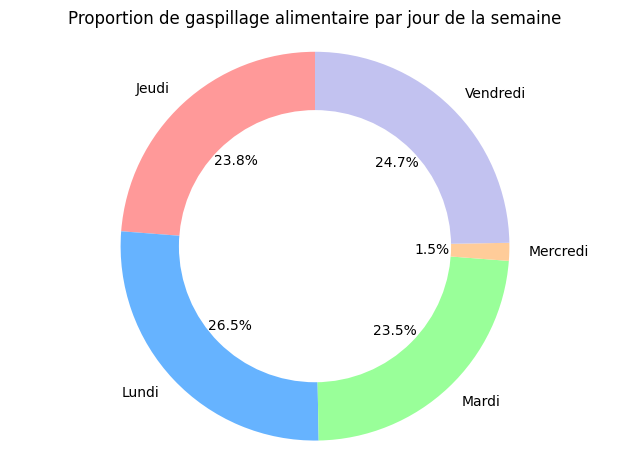

In [7]:
tot_jour1 = cantine.copy()
tot_jour1 = tot_jour1.groupby('jour')['gaspillage_volume'].sum().reset_index()

labels = tot_jour1['jour']
sizes = tot_jour1['gaspillage_volume']
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0']
 
fig1, ax1 = plt.subplots()
ax1.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
ax1.axis('equal')  
plt.title('Proportion de gaspillage alimentaire par jour de la semaine')
plt.tight_layout()
plt.show()

Pourquoi si peu de service le mercredi ?

In [8]:
# Création d'un petit dataframe pour faire une observation de la représentation de repas servis dans la semaine

tot_jour = data['jour'].value_counts().to_frame().reset_index()
tot_jour.rename(columns=lambda x: x.replace('index', 'jour de la semaine'), inplace=True)
tot_jour.rename(columns=lambda x: x.replace('jour', 'total par jour'), inplace=True)
tot_jour

,total par jour,count
0,Vendredi,23842
1,Lundi,23197
2,Mardi,22891
3,Jeudi,22418
4,Mercredi,523


In [9]:
wednesday = data.loc[(data['jour'] == 'Mercredi')]
wednesday.menu.unique()

array(["['ECOLE', 'crepes fromage', 'lieu', 'marmite du perray', 'Carottes en surgelees', 'Tomme blanche', 'fraises']",
       "['scolaire', 'carottes râpées', 'chipolata/merguez', 'Mogette de Vendée', 'Crème vanille']",
       "['MERCREDI AVEC CLASSE', 'Salade de pâtes agro', 'Grignottes de poulet/moutarde', 'Petits pois boîte', 'Liégeois choco']",
       "['Ecoles', 'Choux blancs mimolette', 'Rôti de porc froid', 'rôti de dinde', 'ketchup', 'Chips', 'Suisses aromatisés']",
       "['Ecole', 'salade au gruyère', 'Rôti de b\\x9cuf', 'ketchup', 'Pommes noisette', 'Banane']",
       "['SCOLAIRE', 'Gaspacho/croûton', 'Poisson surgelé', 'Sauce beurre blanc', 'Carottes 5/1', 'Cantal', 'Banane']"],
      dtype=object)

On observe que dans la colonne menu il y écrit en plus 'école', 'scolaire', 'sorties scolaires' on peut donc en déduire que les établissements ont dû faire des services en plus exceptionnellement à certaines dates. De plus on observe qu'il n'y a qu'un ou trois services par an le mercredi. Il s'agit d'un évènement rare. Pour la modélisation, il serait intéressant de ne pas prendre en compte les mercredis.

In [10]:
# Suppression des mercredis
data = data.loc[(data['jour'] != 'Mercredi')]

## Mois

In [11]:
# Création d'un petit dataframe pour faire une observation de la représentation de repas servis dans le mois
repar_mois = pd.DataFrame(data.mois.value_counts()).reset_index()
repar_mois.rename(columns={'count': 'total'}, inplace=True)
repar_mois

,mois,total
0,Septembre,12313
1,Janvier,11059
2,Novembre,10996
3,Juin,9957
4,Mars,8362
5,Mai,8306
6,Decembre,7948
7,Octobre,7942
8,Avril,6883
9,Fevrier,6763


On observe qu'il y a peu de services en juillet contrairement aux autres, cela est sûrement dû au fait qu'il n'y a pas beaucoup de jours d'école en juillet. Les cantines sont plus fréquentés en septembre et janvier.

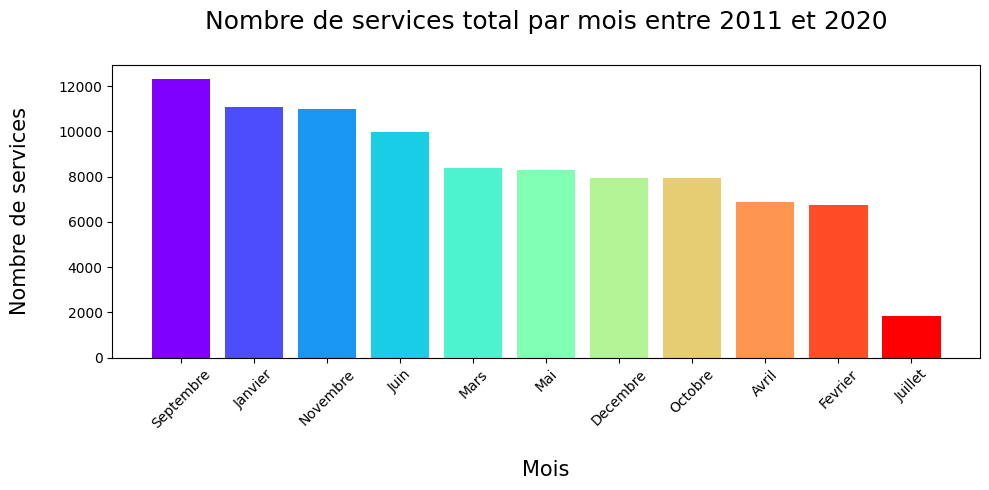

In [12]:
plt.figure(figsize=(10, 5))

mois = repar_mois['mois']
total_services = repar_mois['total']

plt.bar(mois, total_services, color=cm.rainbow(np.linspace(0, 1, len(mois))))
plt.xticks(rotation=45)
plt.title("Nombre de services total par mois entre 2011 et 2020\n", fontsize=18)
plt.ylabel("Nombre de services\n", fontsize=15)
plt.xlabel("\nMois", fontsize=15)
plt.tight_layout()
plt.show()

On observe que les mois d'août ne sont pas présent dans ce graphique et qu'il y a une faible fréquentation à la cantine les mois de juillet car les écoles sont fermées pendant la période d'été.

/tmp/ipykernel_1841/1259439091.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='mois', y='reel', data=data, palette="coolwarm")


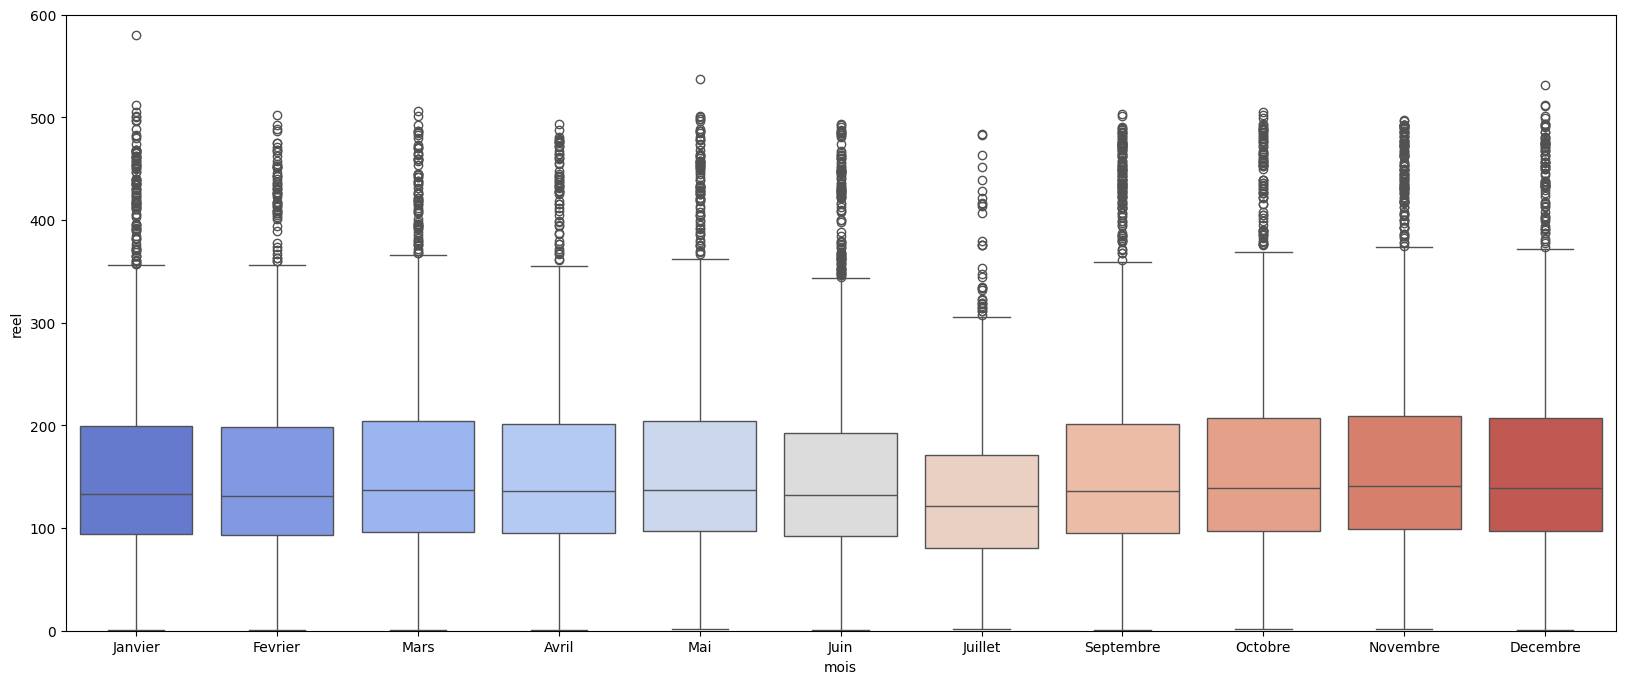

In [13]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(20, 8))
#sns.set(style='whitegrid')
ax.set(ylim=(0, 600))
ax = sns.boxplot(x='mois', y='reel', data=data, palette="coolwarm")

#### Représentation de l'effectif par années

In [14]:
data.annee_scolaire.value_counts()

annee_scolaire
2016-2017    11432
2011-2012    11306
2018-2019    11286
2017-2018    11256
2015-2016    10898
2013-2014    10252
2014-2015     9362
2010-2011     7263
2012-2013     5118
2019-2020     4175
Name: count, dtype: int64

On observe qu'il y a moins de données sur certaines années scolaires.

In [15]:
df_year_sco = cantine.copy()

df_year_sco['date'] = pd.to_datetime(df_year_sco['date'])

def get_annee_scolaire(date):
    if date.month >= 9:  # Septembre ou après
        return f"{date.year}-{date.year + 1}"  # Année actuelle et suivante
    else:  # Avant Septembre
        return f"{date.year - 1}-{date.year}"  # Année précédente et actuelle


# Appliquer la fonction pour créer la colonne 'annee_scolaire'
df_year_sco['annee_scolaire'] = df_year_sco['date'].apply(get_annee_scolaire)

# Afficher le DataFrame
df_year_sco.head()

,date,prevision,reel,effectif,nos,ind,greves_manquantes,menu,ferie,veille_ferie,retour_ferie,vacances,retour_vacances,veille_vacances,inc_grippe,inc_gastro,inc_varicelle,fete_musulmane,ramadan,fete_chretienne,fete_juive,jour,semaine,mois,gaspillage_volume,gaspillage_pourcentage,greves,annee_scolaire
0,2011-01-03,12289,11129,17373,1.0,0,0,"['Pamplemousse', 'Hachis Parmentier', 'Salade ...",0,0,0,0,1,0,10505,6554,551,0,0,0,0,Lundi,1,Janvier,1160,9.439336,1.0,2010-2011
1,2011-01-04,12558,11808,17373,0.0,0,0,"['Crêpe au fromage', 'emincé de volaille à la ...",0,0,0,0,0,0,10505,6554,551,0,0,0,0,Mardi,1,Janvier,750,5.972289,0.0,2010-2011
2,2011-01-06,12753,11741,17373,0.0,0,0,"['thon', 'Mâche au thon', 'Croziflette', 'des ...",0,0,0,0,0,0,10505,6554,551,0,0,1,0,Jeudi,1,Janvier,1012,7.935388,0.0,2010-2011
3,2011-01-07,12812,12322,17373,0.0,0,0,"['Choux blancs mimolette', 'milanette en des',...",0,0,0,0,0,0,10505,6554,551,0,0,1,0,Vendredi,1,Janvier,490,3.824539,0.0,2010-2011
4,2011-01-10,12309,11302,17373,0.0,0,0,"['Endives / demi-\x9cuf', 'paella de la mer', ...",0,0,0,0,0,0,7200,6453,493,0,0,0,0,Lundi,2,Janvier,1007,8.181006,0.0,2010-2011


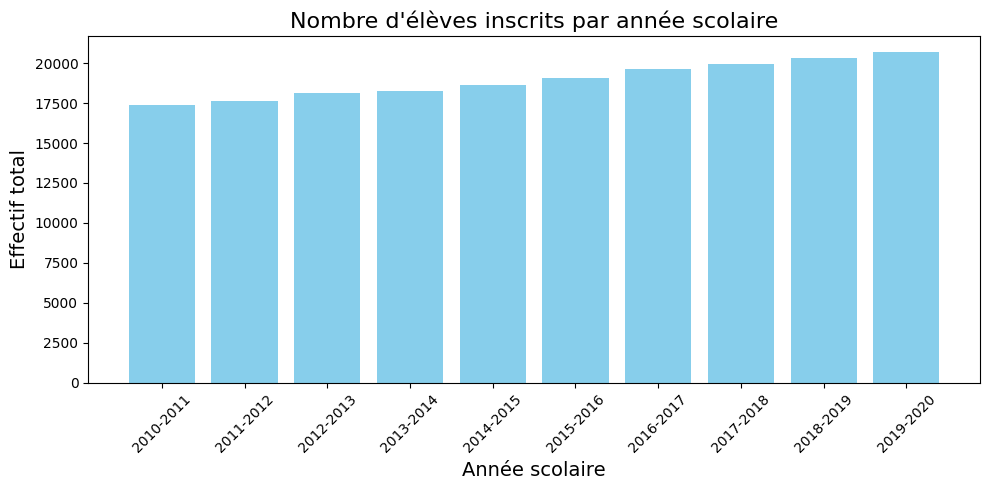

In [16]:
#df_date = df_date.set_index('date')

effectif_par_annee = df_year_sco.groupby('annee_scolaire')['effectif'].first().reset_index()

plt.figure(figsize=(10, 5))
plt.bar(effectif_par_annee['annee_scolaire'], effectif_par_annee['effectif'], color='skyblue')
plt.title("Nombre d'élèves inscrits par année scolaire", fontsize=16)
plt.xlabel("Année scolaire", fontsize=14)
plt.ylabel("Effectif total", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

On se rend compte qu'il y a une évolution constante dans l'effectifs. Il y a une évolution stable dans les années scolaires à partir de 2015. 

## Traitement des journées exceptionnelles

In [17]:
q_freq_01 = pd.DataFrame(data.groupby(['site_nom', 'annee_scolaire'])['reel'].apply(lambda x:x.quantile(.01)))
q_freq_99 = pd.DataFrame(data.groupby(['site_nom', 'annee_scolaire'])['reel'].apply(lambda x:x.quantile(.99)))

df_temp = pd.merge(q_freq_01, q_freq_99, on = ['site_nom', 'annee_scolaire'])
df_temp.rename(columns=lambda x:x.replace('reel_x', 'q_freq_01'), inplace=True)
df_temp.rename(columns=lambda x:x.replace('reel_y', 'q_freq_99'), inplace=True)

temp = pd.merge(df_temp, data, on = ['site_nom', 'annee_scolaire'])

temp.reel[temp.reel < temp.q_freq_01] = temp.q_freq_01
temp.reel[temp.reel > temp.q_freq_99] = temp.q_freq_99

/tmp/ipykernel_1841/2052792087.py:10: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  temp.reel[temp.reel < temp.q_freq_01] = temp.q_freq_01
/tmp/ipykernel_1841/2052792087.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy o

## Années scolaires

### Année scolaire 2011-2012

In [18]:
# création df sur les effectifs
df_freq = cantine[['prevision', 'reel', 'effectif', 'date', 'jour', 'semaine', 'mois', 'ferie', 'greves','menu','gaspillage_volume']]
df_freq = df_freq.set_index('date')
df_freq.head()

,prevision,reel,effectif,jour,semaine,mois,ferie,greves,menu,gaspillage_volume
date,,,,,,,,,,
2011-01-03,12289,11129,17373,Lundi,1,Janvier,0,1.0,"['Pamplemousse', 'Hachis Parmentier', 'Salade ...",1160
2011-01-04,12558,11808,17373,Mardi,1,Janvier,0,0.0,"['Crêpe au fromage', 'emincé de volaille à la ...",750
2011-01-06,12753,11741,17373,Jeudi,1,Janvier,0,0.0,"['thon', 'Mâche au thon', 'Croziflette', 'des ...",1012
2011-01-07,12812,12322,17373,Vendredi,1,Janvier,0,0.0,"['Choux blancs mimolette', 'milanette en des',...",490
2011-01-10,12309,11302,17373,Lundi,2,Janvier,0,0.0,"['Endives / demi-\x9cuf', 'paella de la mer', ...",1007


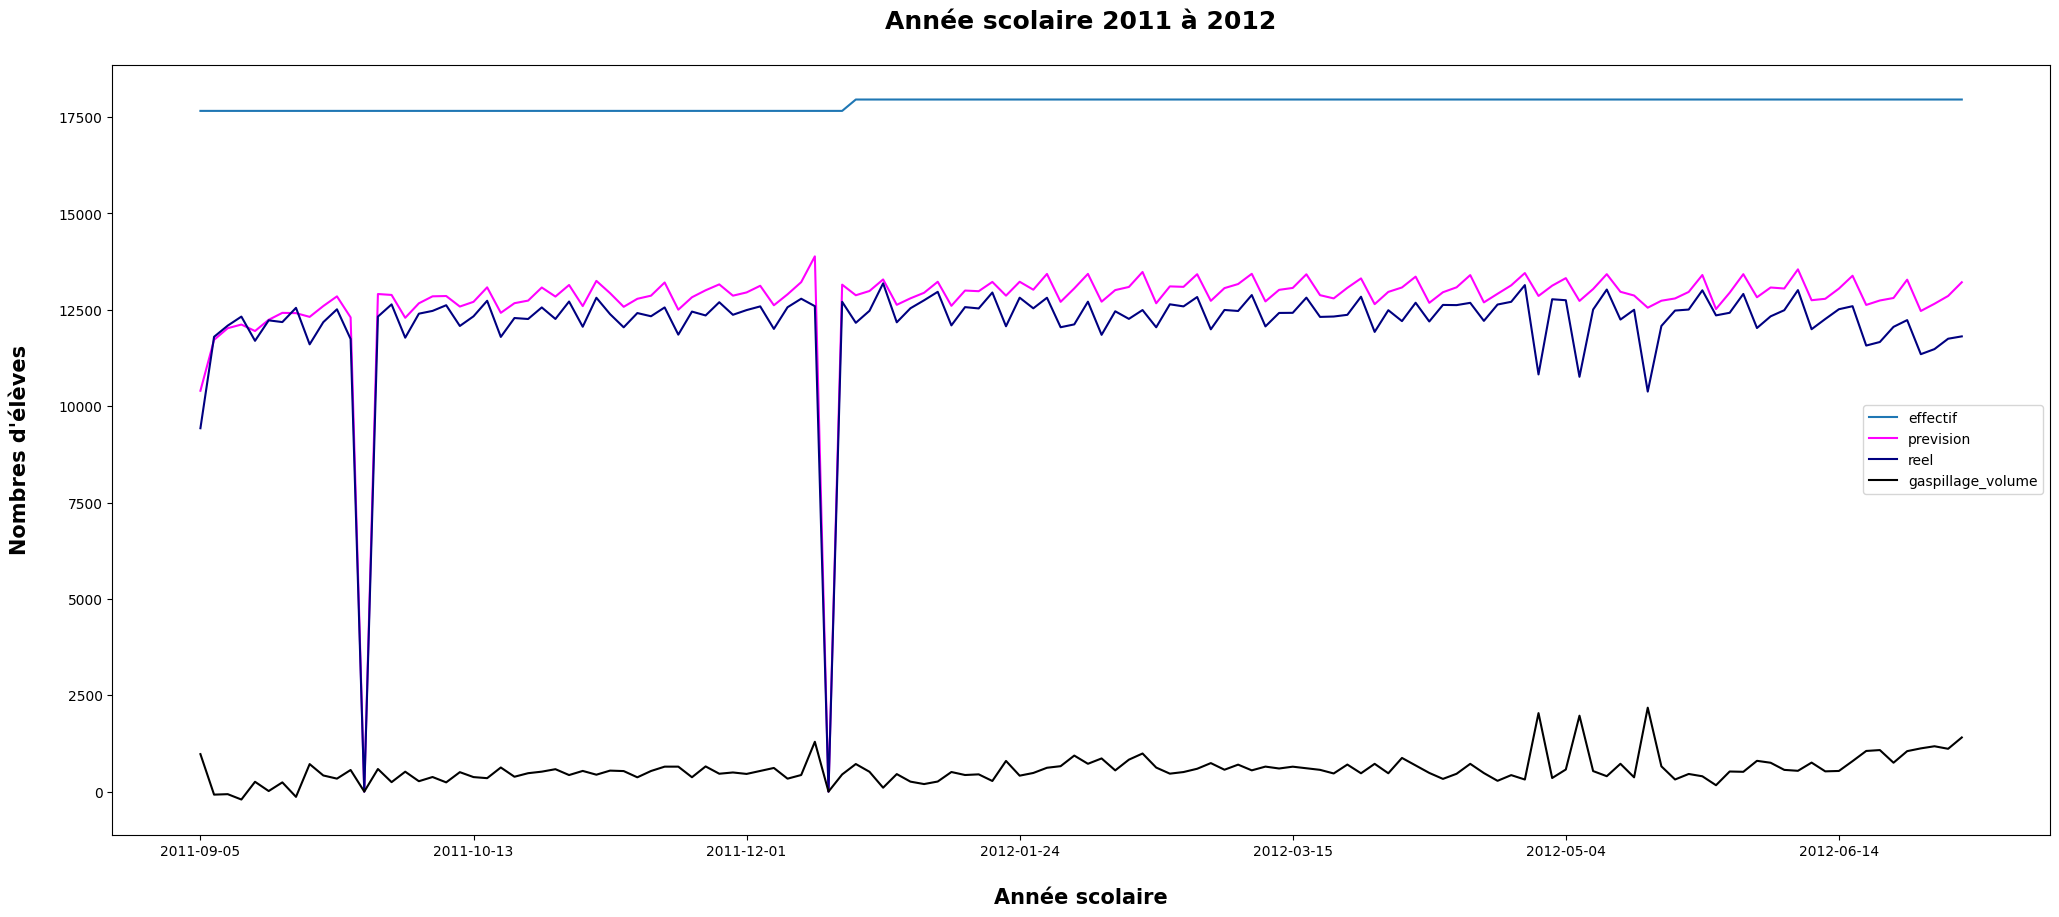

In [19]:
# année scolaire 2011 à 2012
plt.figure(figsize = (25,10))
df_freq['effectif']['2011-09':'2012-07'].plot(label='effectif')
df_freq['prevision']['2011-09':'2012-07'].plot(color='magenta')
df_freq['reel']['2011-09':'2012-07'].plot(color='navy')
df_freq['gaspillage_volume']['2011-09':'2012-07'].plot(color='black')

plt.title("Année scolaire 2011 à 2012\n", fontsize=18, weight='bold')
plt.xlabel("\nAnnée scolaire", fontsize=15, weight='bold')
plt.ylabel("Nombres d'élèves\n", fontsize=15, weight='bold')
plt.legend()
plt.show()

On observe que du 02 eu 06 mai 2011, il n'y aucune donnée prévisionnelle et réelle, et qu'en regardant sur le mois d'avril on observe qu'il y a un trou dans les dates à partir du 22 avril 2011 et au 13 juin 2011 qui est un jour férié.

Pour les deux premières semaines de septembre, le prévisionnel est plus faible que la fréquentation réelle des cantines ce qui correspond à la rentrée scolaire.

On observe 4 grosses de fréquentations au niveau des données sur les prévisions et les repas servis en septembre, en octobre, en décembre et en janvier.

Pour ces 4 chutes cela est dû à des grèves, il y a eu un mouvement de grève les 27 septembre 2011, 11 octobre 2011, 13 et du 15 décembre 2011 et 31 janvier 2012.

On observe également qu'en septembre, il y a eu des erreurs au niveau du prévisionnel.

Après quelques recherches, les vacances commencent le 23 avril pour revenir à l'école le 9 mai 2011. 

In [20]:
# suppression des lignes où les élèves sont en vacances aux dates : du 2011-05-01 au 2011-05-08 compris
cantine = cantine.drop([56, 57, 58, 59, 60])

# Suppression des jours férié
cantine = cantine.loc[(cantine['ferie'] != 1)]

### Année scolaire 2012 à 2013

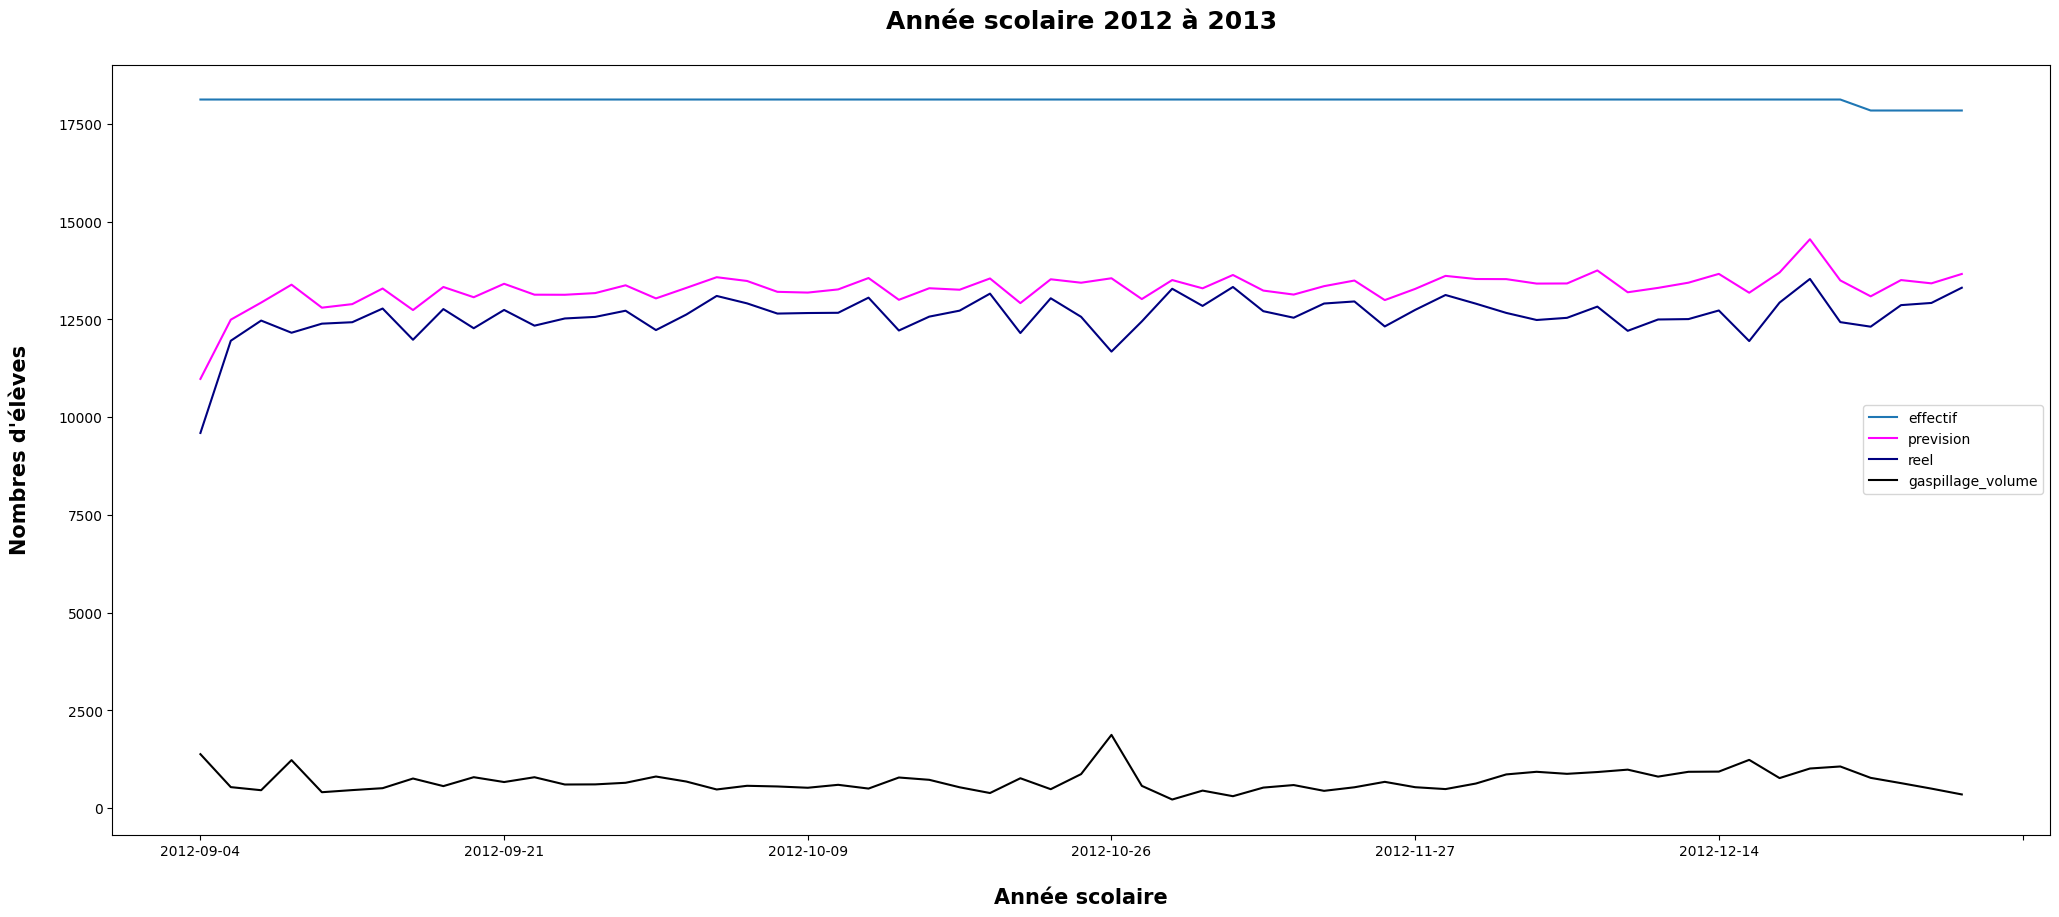

In [21]:
plt.figure(figsize = (25,10))
df_freq['effectif']['2012-09':'2013-07'].plot(label='effectif')
df_freq['prevision']['2012-09':'2013-07'].plot(color='magenta')
df_freq['reel']['2012-09':'2013-07'].plot(color='navy')
df_freq['gaspillage_volume']['2012-09':'2013-07'].plot(color='black')

plt.title("Année scolaire 2012 à 2013\n", fontsize=18, weight='bold')
plt.xlabel("\nAnnée scolaire", fontsize=15, weight='bold')
plt.ylabel("Nombres d'élèves\n", fontsize=15, weight='bold')
plt.legend()
plt.show()

On observe 2 chutes de données dans le prévisionnel et les repas servis en janvier et en février qui correspondent à des grèves. Il y a aussi une chute de repas servis en mars qui correspondent aussi à des grèves. 

### Année scolaire 2013 à 2014

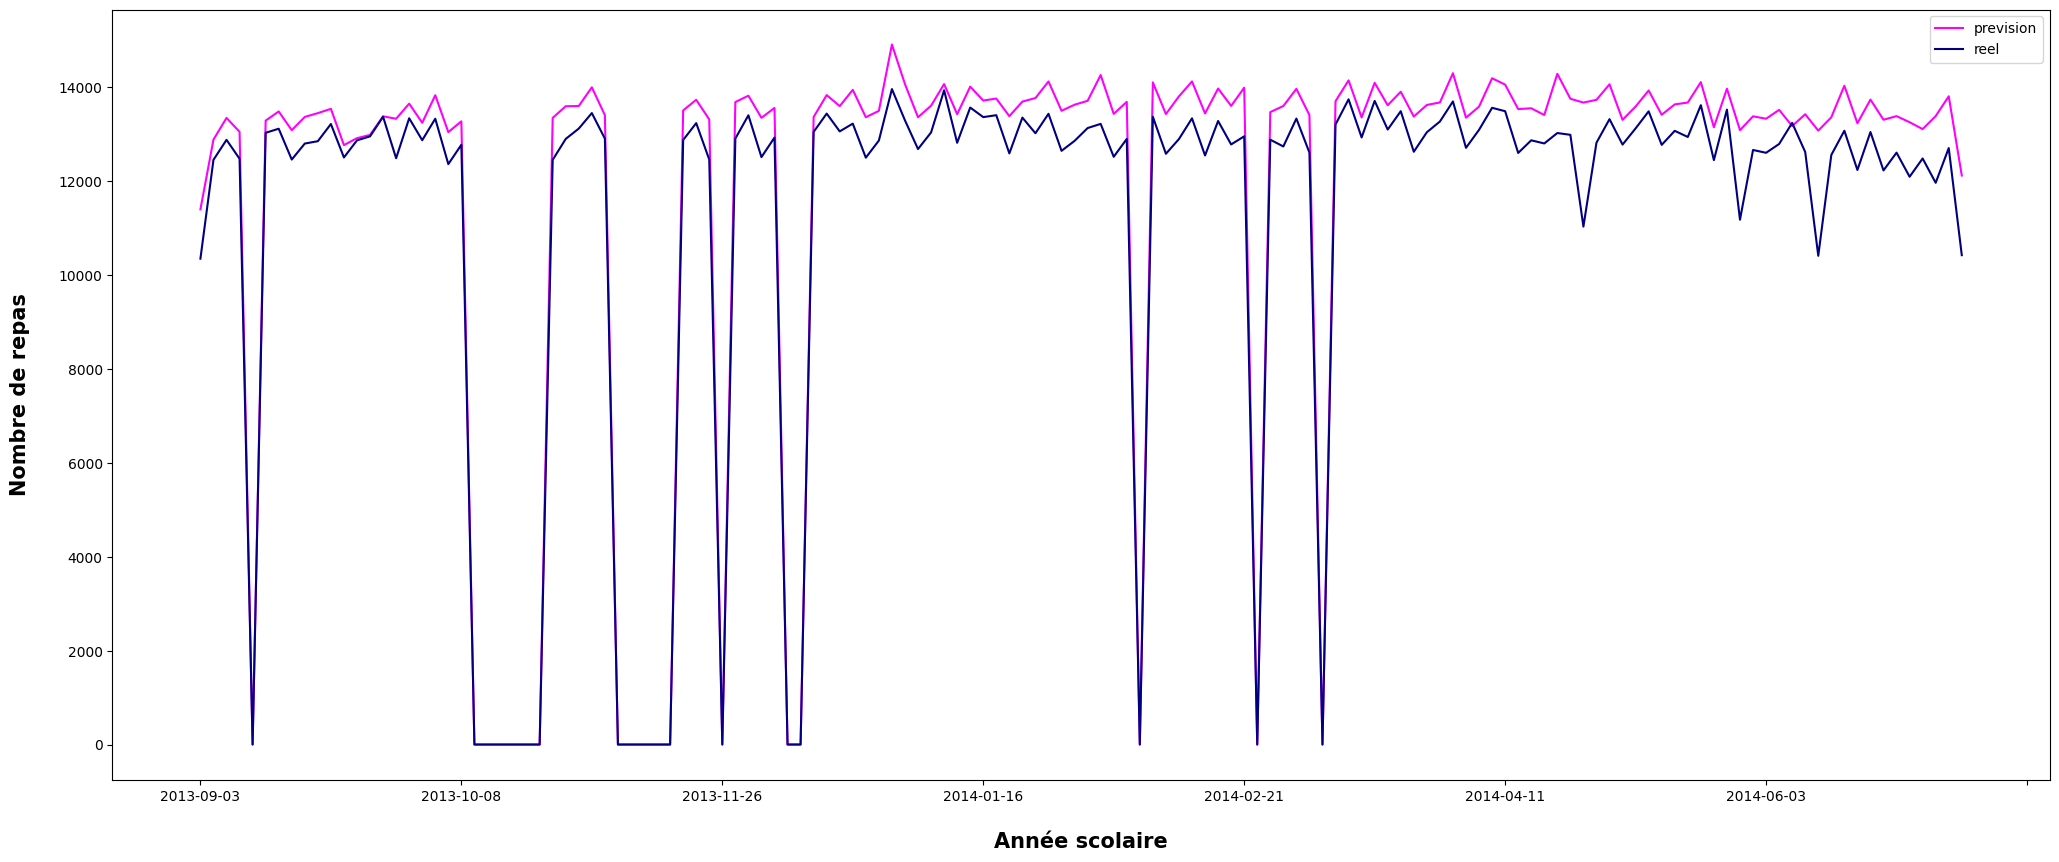

In [22]:
plt.figure(figsize = (25,10))
#df_freq['effectif']['2013-09':'2014-07'].plot(label='effectif')
df_freq['prevision']['2013-09':'2014-07'].plot(color='magenta')
df_freq['reel']['2013-09':'2014-07'].plot(color='navy')
#df_freq['gaspillage_volume']['2013-09':'2014-07'].plot(color='black')

#plt.title("Année scolaire 2013 à 2014\n", fontsize=18, weight='bold')
plt.xlabel("\nAnnée scolaire", fontsize=15, weight='bold')
plt.ylabel("Nombre de repas\n", fontsize=15, weight='bold')
plt.legend()
plt.show()

Dans cette année scolaire, on observe 9 chutes dans les prévisions et les repas servis ce qui, comparée aux années précédentes est plus conséquent. 
Le 10 septembre 2013, cela correspond à un mouvement de grève.
Du 10 au 18 octobre et du 14 au 19 novembre 2013, il y a eu deux grands mouvements de grève dans l'éducation nationale.
Le 26 novembre 2016, il y a eu une grève sur la réforme des retraites.
Les 5 et 6 décembre 2013, il y a eu une grève contre la réforme scolaire.
Les 06 et 24 février, le 18 mars et le 15 mai 2013, les enseignants étaient en grèves.

### Année scolaire 2014 à 2015

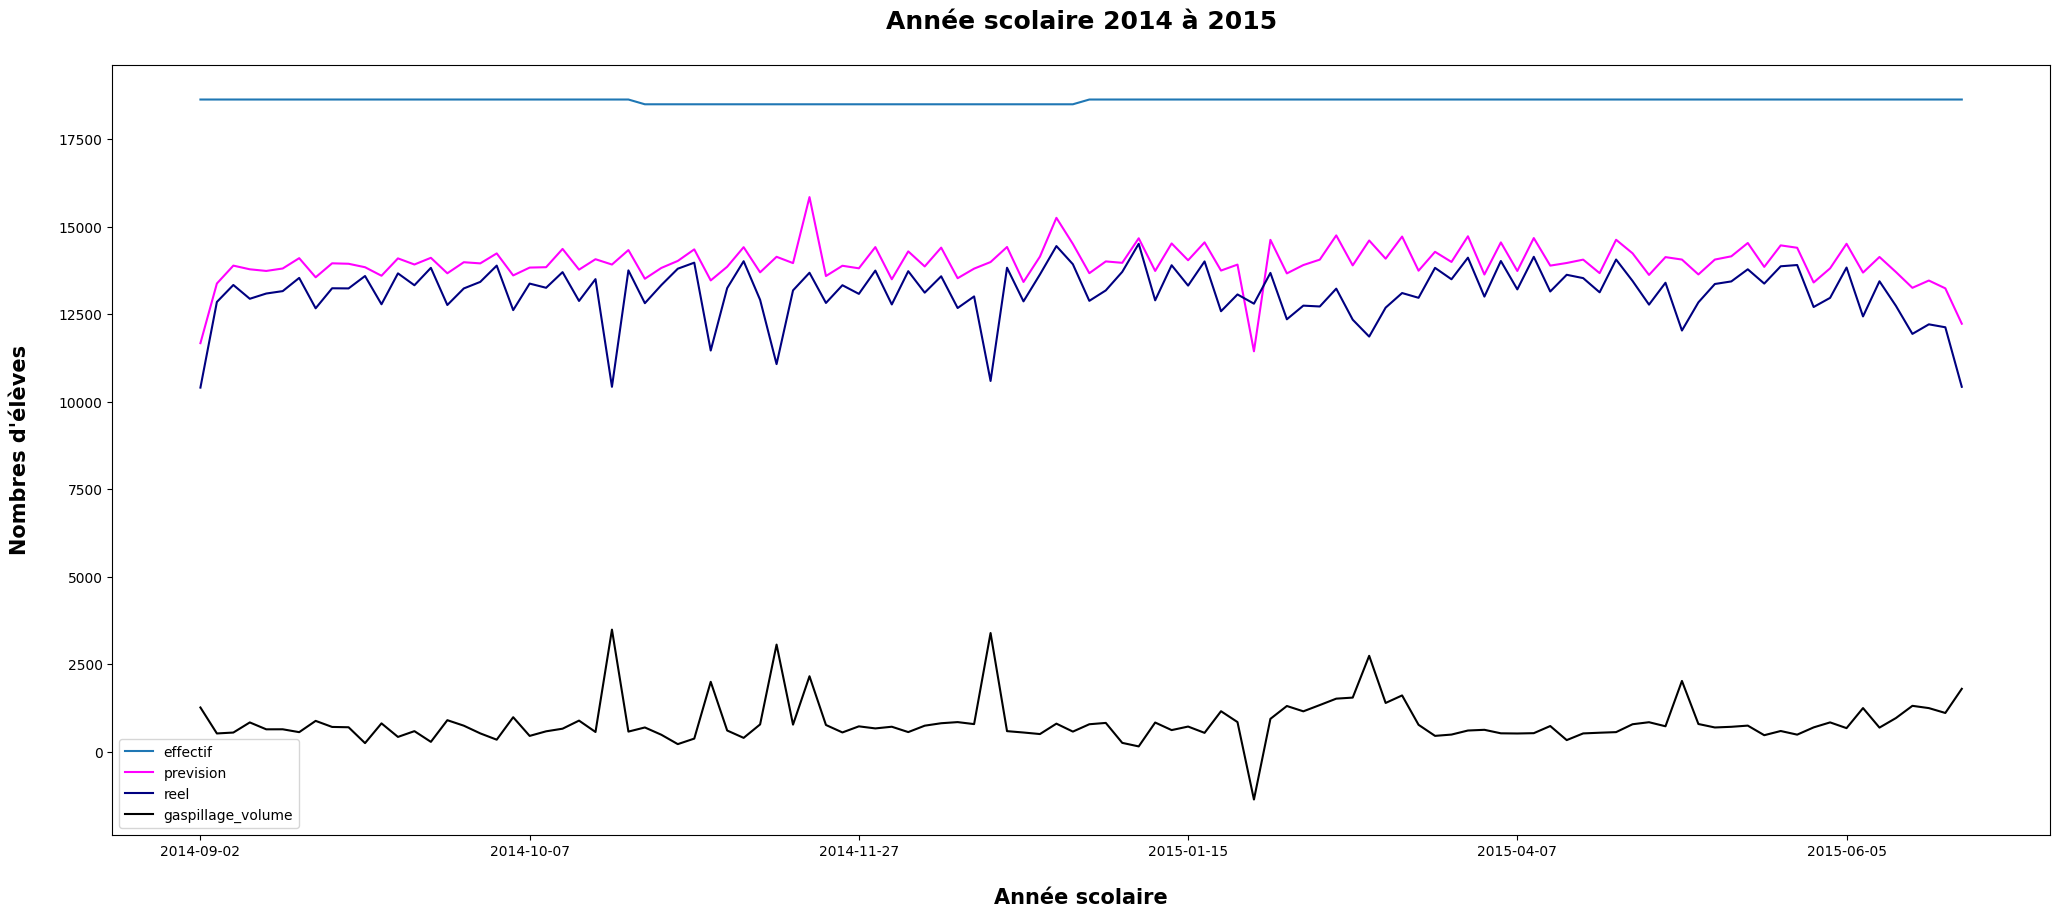

In [23]:
plt.figure(figsize = (25,10))
df_freq['effectif']['2014-09':'2015-07'].plot(label='effectif')
df_freq['prevision']['2014-09':'2015-07'].plot(color='magenta')
df_freq['reel']['2014-09':'2015-07'].plot(color='navy')
df_freq['gaspillage_volume']['2014-09':'2015-07'].plot(color='black')

plt.title("Année scolaire 2014 à 2015\n", fontsize=18, weight='bold')
plt.xlabel("\nAnnée scolaire", fontsize=15, weight='bold')
plt.ylabel("Nombres d'élèves\n", fontsize=15, weight='bold')
plt.legend()
plt.show()

Dans les prévisionnels et les repas servis on observe que le graphiques est en dent de scie.
On observe sur le graphique qu'il y a eu une erreur au niveau des prévisions par rapport aux repas servis.
On observe qu'il manque les données sur le mois de mars 2015. 

### Année scolaire 2015 à 2016

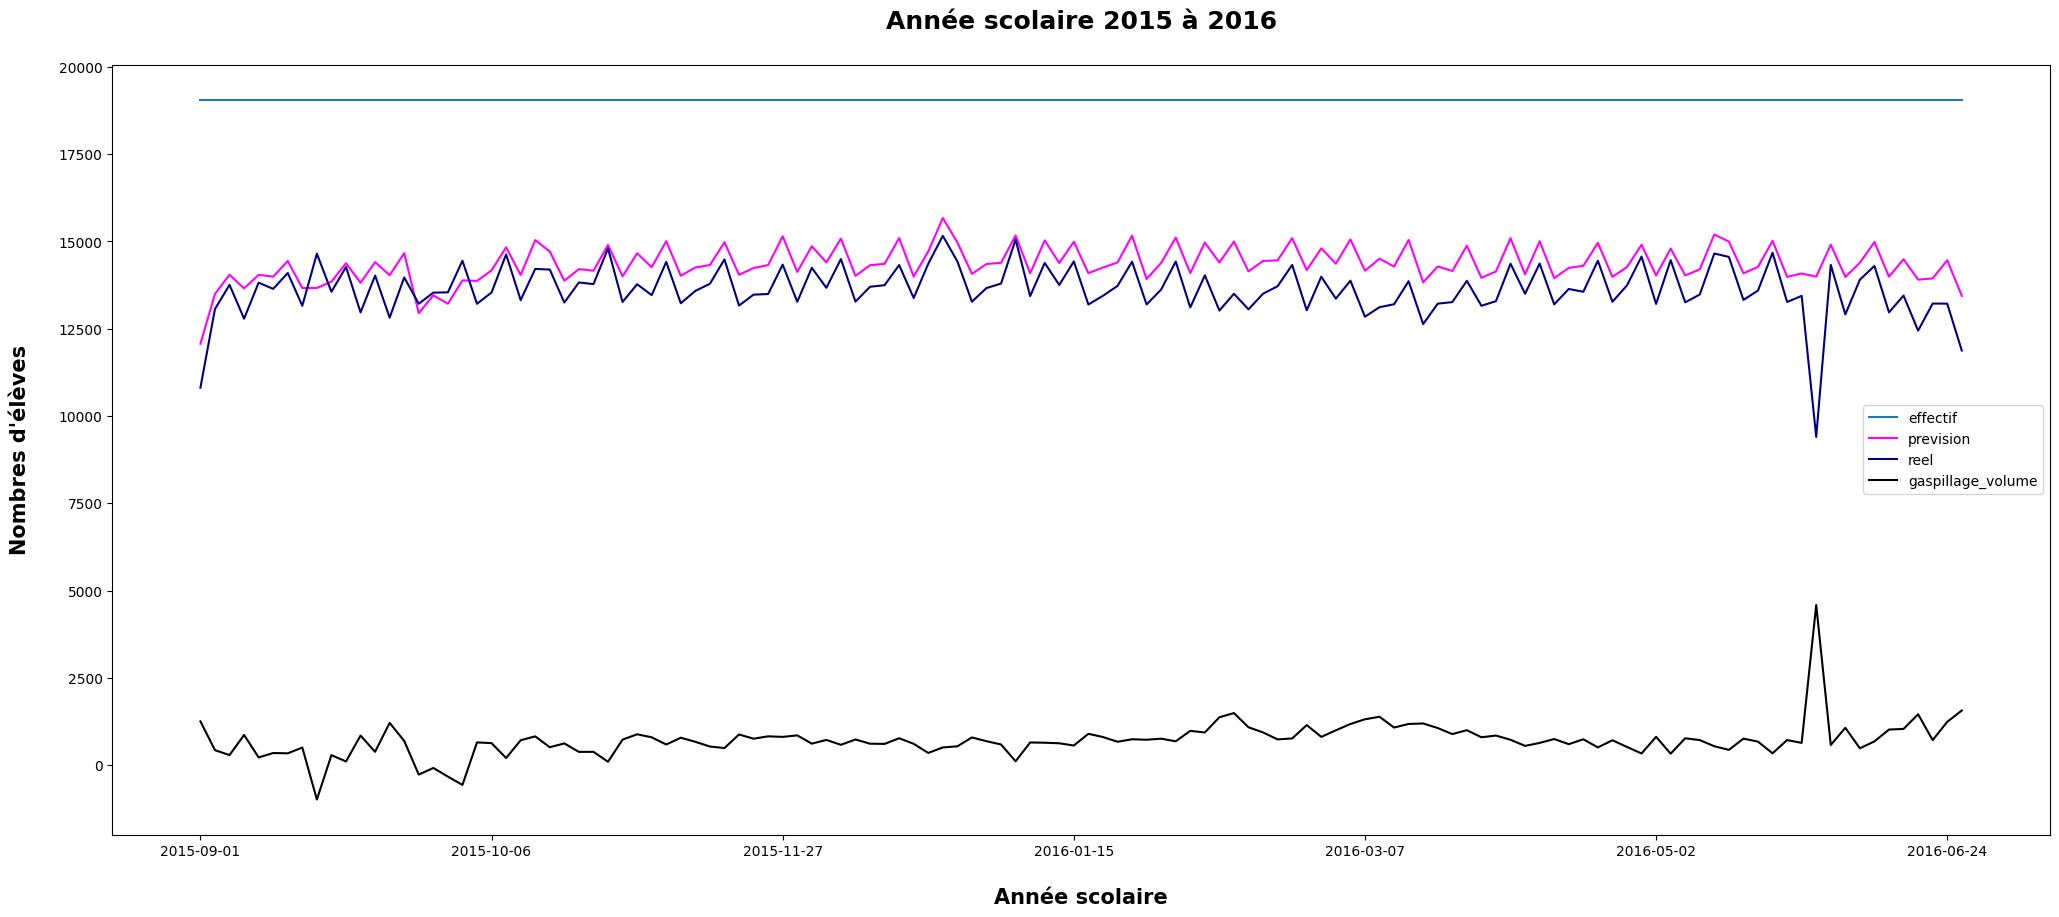

In [24]:
plt.figure(figsize = (25,10))
df_freq['effectif']['2015-09':'2016-07'].plot(label='effectif')
df_freq['prevision']['2015-09':'2016-07'].plot(color='magenta')
df_freq['reel']['2015-09':'2016-07'].plot(color='navy')
df_freq['gaspillage_volume']['2015-09':'2016-07'].plot(color='black')

plt.title("Année scolaire 2015 à 2016\n", fontsize=18, weight='bold')
plt.xlabel("\nAnnée scolaire", fontsize=15, weight='bold')
plt.ylabel("Nombres d'élèves\n", fontsize=15, weight='bold')
plt.legend()
plt.show()

On observe qu'il y a eu des erreurs de prévisionels en septembre et en octobre. On constate également une chute dans les prévisionnels où ils ont prévus moins de repas, pour les repas servis le 02 juin et le 04 juillet 2016. La hausse en septembre de la fréquentation de la cantine, peut-être dû à la rentrée scolaire.

### Année scolaire 2016 à 2017

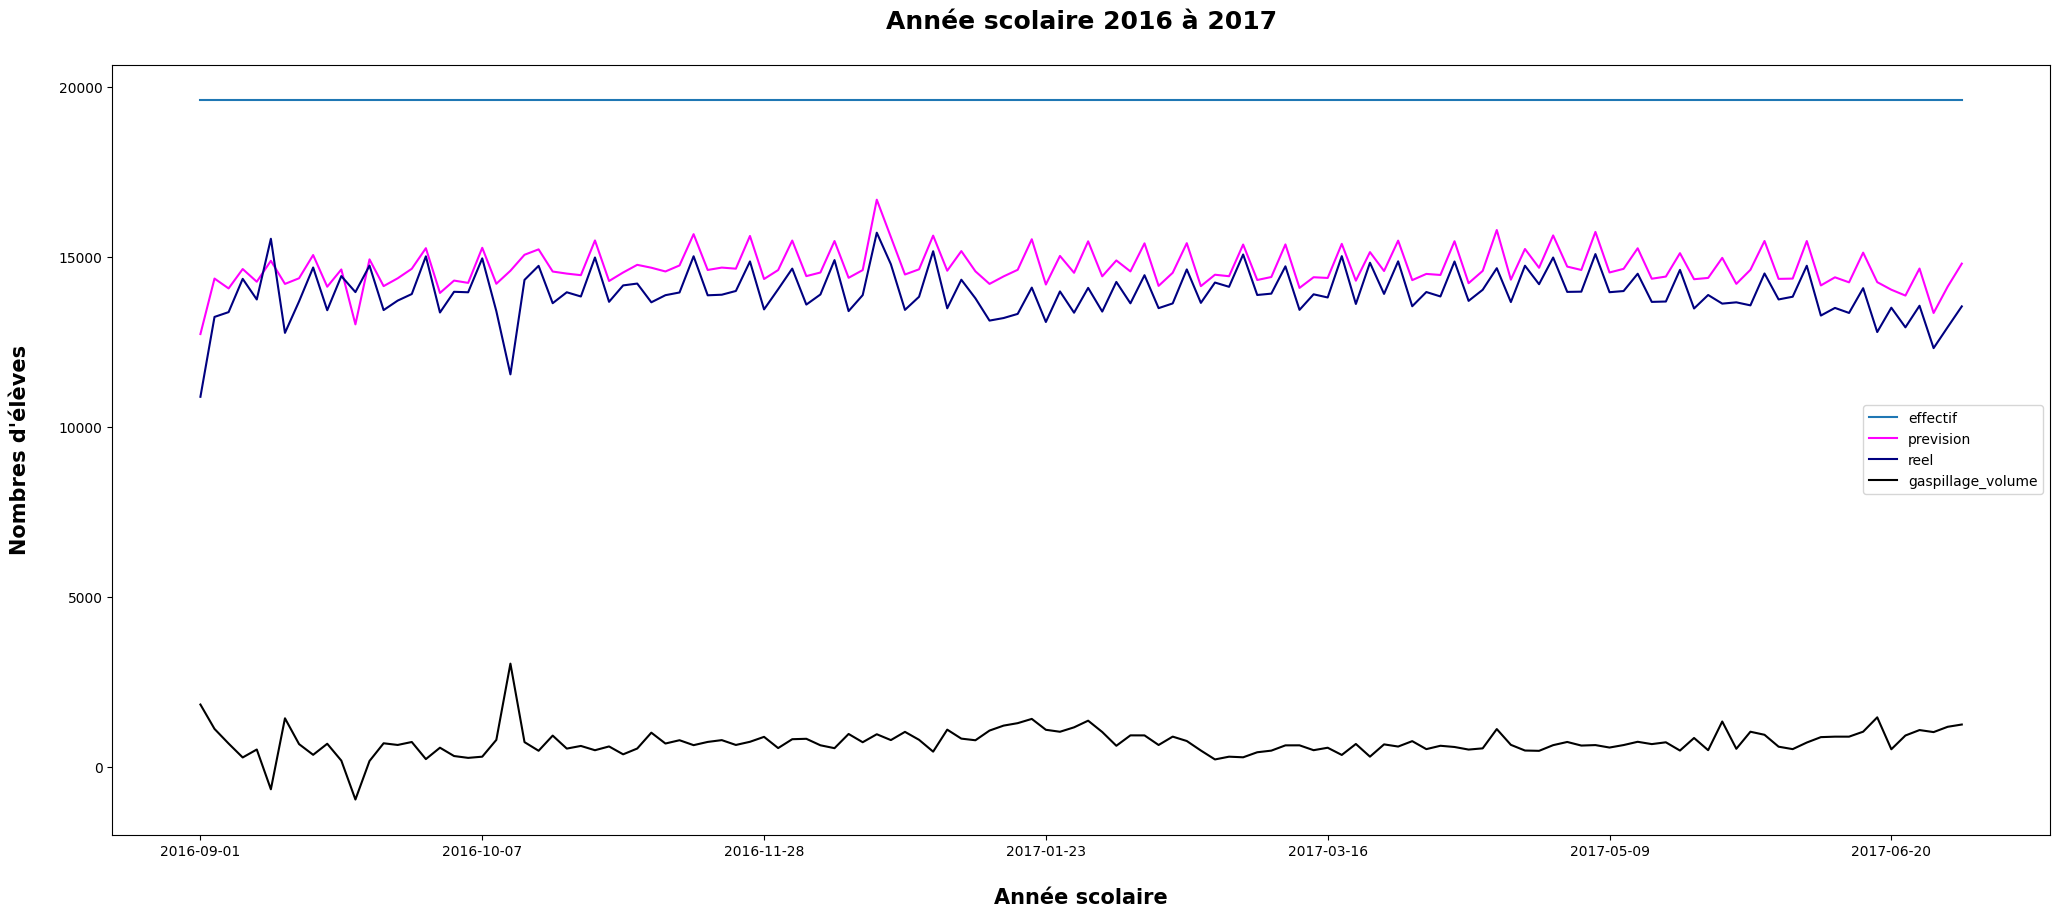

In [25]:
plt.figure(figsize = (25,10))
df_freq['effectif']['2016-09':'2017-07'].plot(label='effectif')
df_freq['prevision']['2016-09':'2017-07'].plot(color='magenta')
df_freq['reel']['2016-09':'2017-07'].plot(color='navy')
df_freq['gaspillage_volume']['2016-09':'2017-07'].plot(color='black')

plt.title("Année scolaire 2016 à 2017\n", fontsize=18, weight='bold')
plt.xlabel("\nAnnée scolaire", fontsize=15, weight='bold')
plt.ylabel("Nombres d'élèves\n", fontsize=15, weight='bold')
plt.legend()
plt.show()

On observe qu'en septembre 2016, il y a eu une hausse de repas servis le 09 septembre 2016 et une baisse de prévisionnels le 22 septembre.

### Année scolaire 2017 à 2018

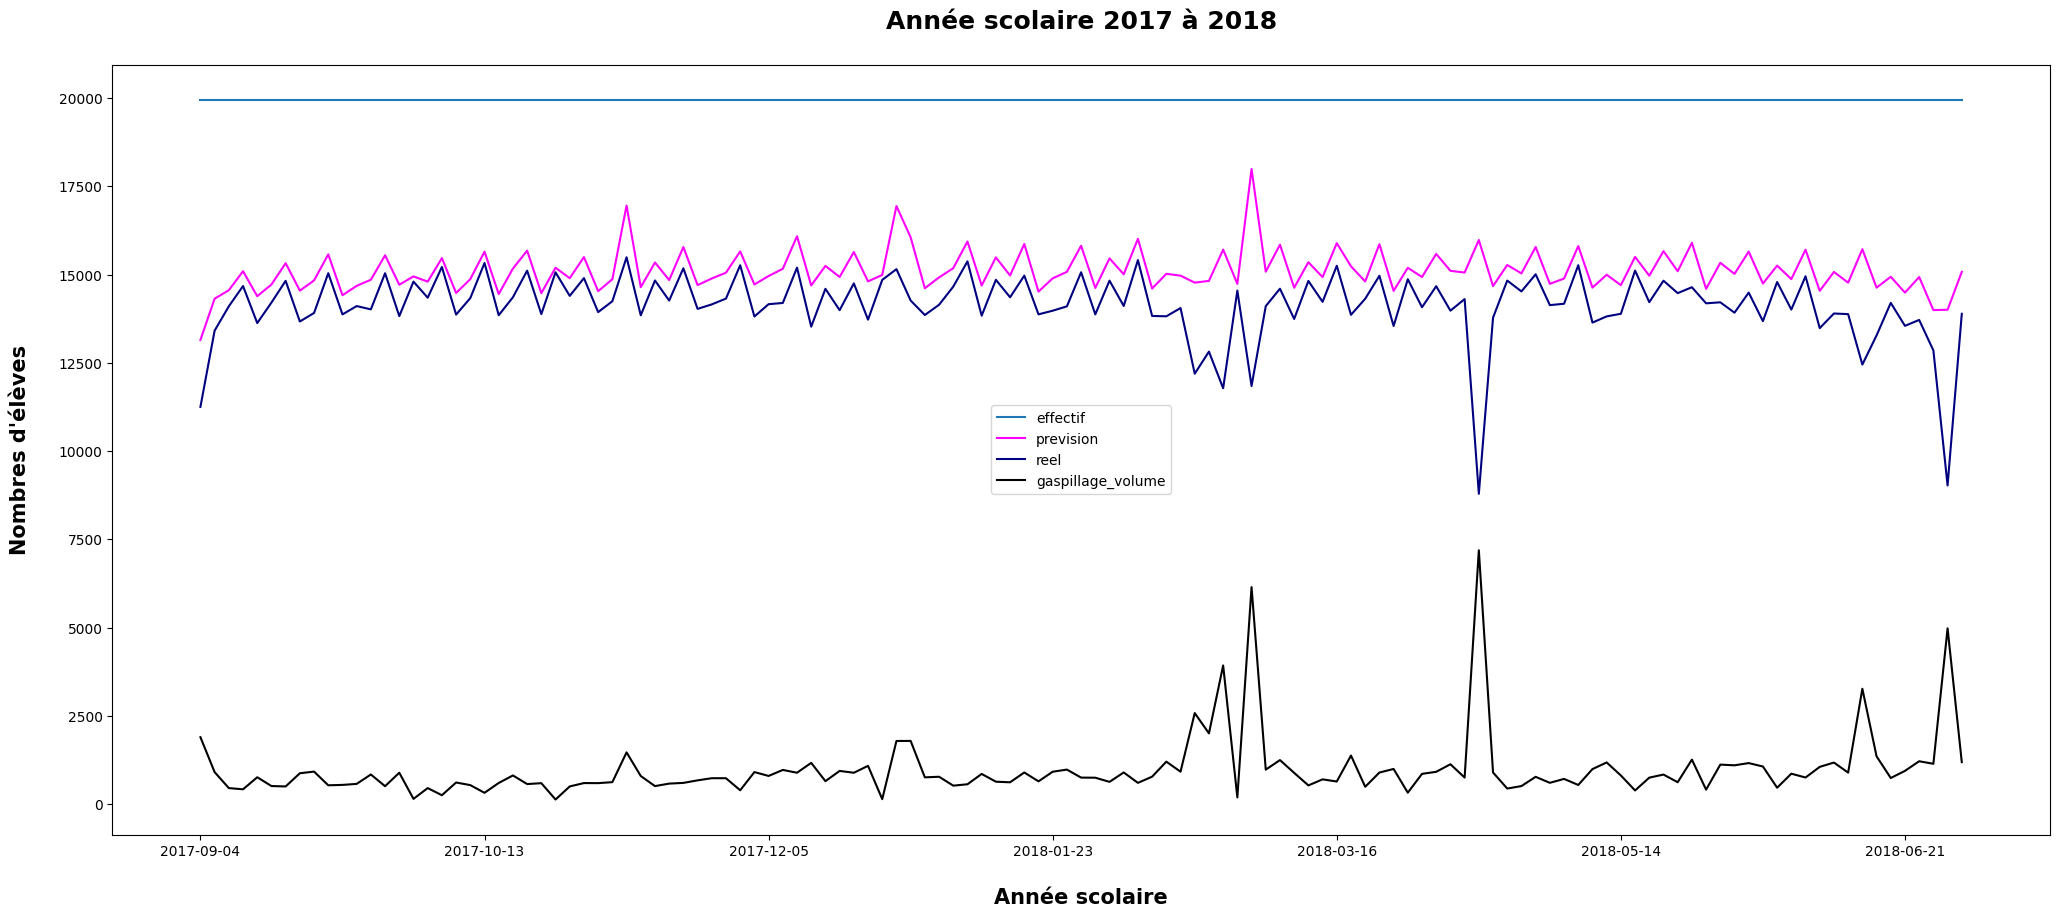

In [26]:
plt.figure(figsize = (25,10))
df_freq['effectif']['2017-09':'2018-07'].plot(label='effectif')
df_freq['prevision']['2017-09':'2018-07'].plot(color='magenta')
df_freq['reel']['2017-09':'2018-07'].plot(color='navy')
df_freq['gaspillage_volume']['2017-09':'2018-07'].plot(color='black')

plt.title("Année scolaire 2017 à 2018\n", fontsize=18, weight='bold')
plt.xlabel("\nAnnée scolaire", fontsize=15, weight='bold')
plt.ylabel("Nombres d'élèves\n", fontsize=15, weight='bold')
plt.legend()
plt.show()

On observe deux chutes au niveau des repas servis contrairement aux prévisionnels en septembre cela peut correspondre à la période de la rentrée scolaire et une chute en juin qui sont renseignées par des "menu dépannage". En février et avril, on observe une baisse de fréquentation de la cantine, mais qu'ils avaient prévus plus dans le prévisionnel.

### Année scolaire 2018 à 2019

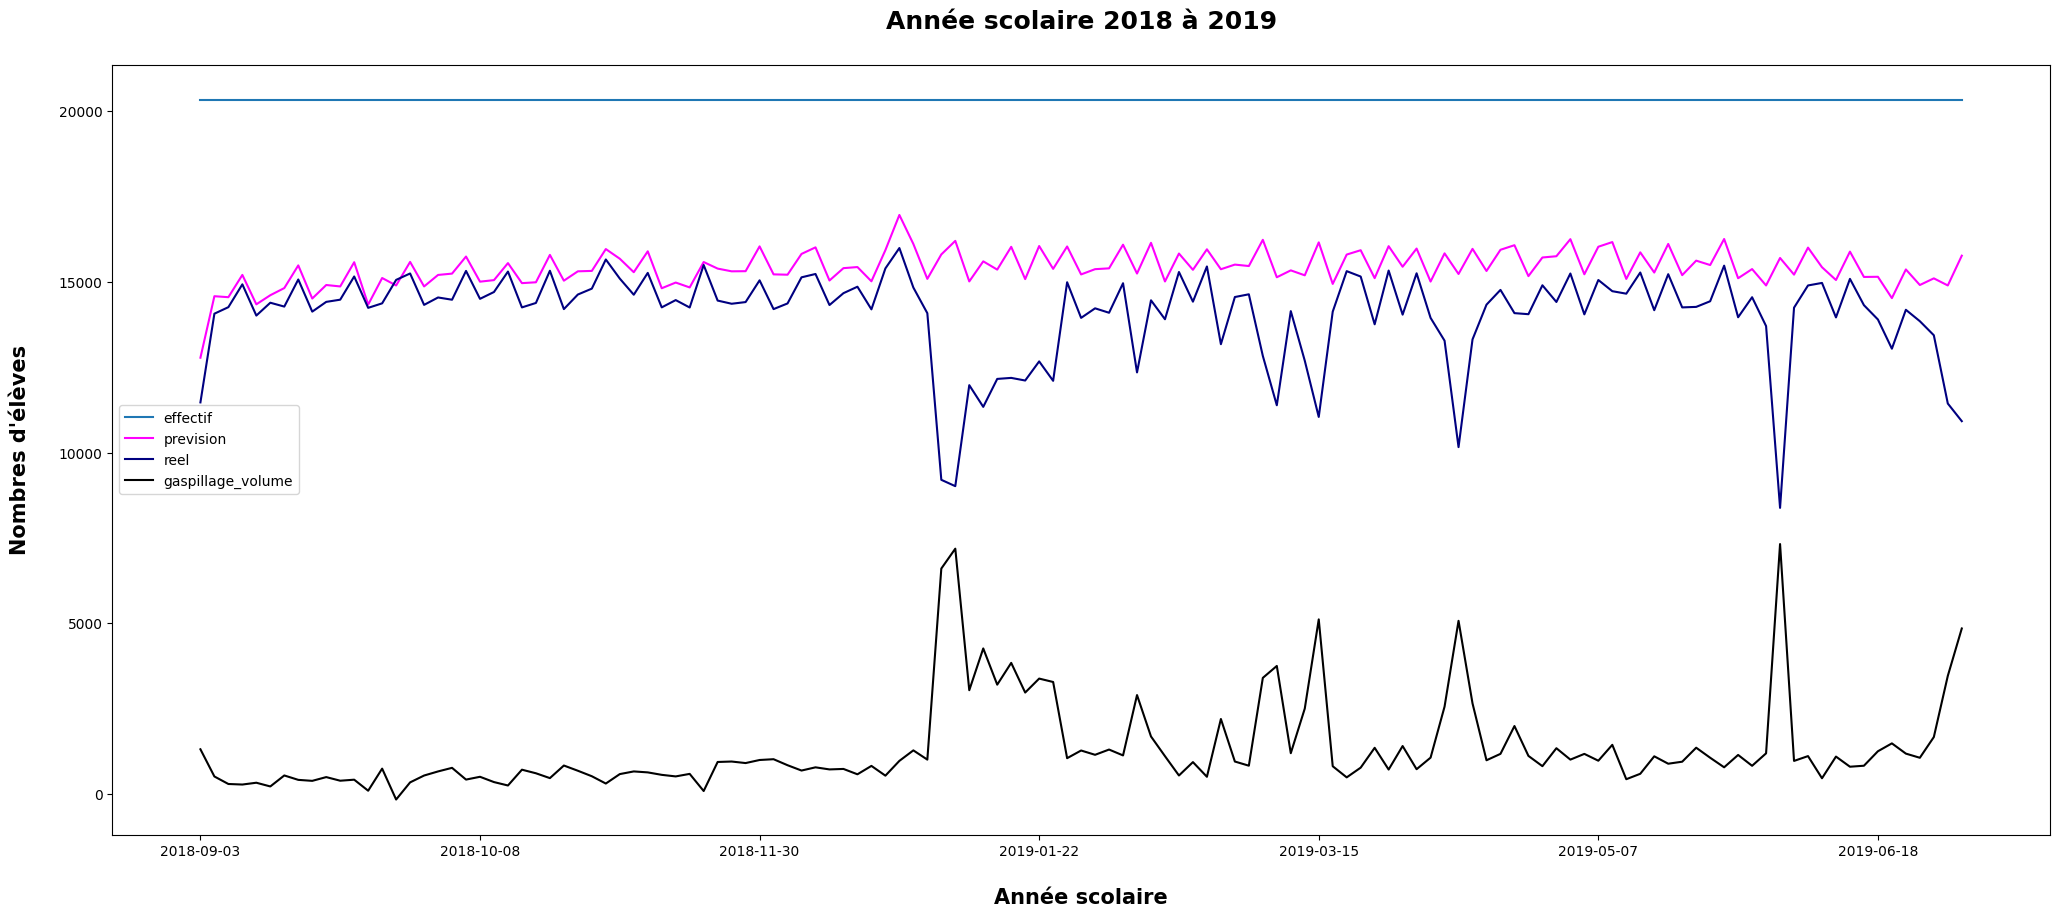

In [27]:
plt.figure(figsize = (25,10))
df_freq['effectif']['2018-09':'2019-07'].plot(label='effectif')
df_freq['prevision']['2018-09':'2019-07'].plot(color='magenta')
df_freq['reel']['2018-09':'2019-07'].plot(color='navy')
df_freq['gaspillage_volume']['2018-09':'2019-07'].plot(color='black')

plt.title("Année scolaire 2018 à 2019\n", fontsize=18, weight='bold')
plt.xlabel("\nAnnée scolaire", fontsize=15, weight='bold')
plt.ylabel("Nombres d'élèves\n", fontsize=15, weight='bold')
plt.legend()
plt.show()

On observe sur le graphique une baisse de la fréquentation en janvier, février, mars, avril, juin et juillet.

=> Pour conclure, il y a des journées atypiques qui correspondent à des périodes de grèves, à la rentrée scolaire et à la fin d'année scolaire, et à des périodes de données manquantes. 

## Traitement des menus

### Création d'un dataframe pour créer les catégories de menus

In [28]:
#création d'un corpus de mots à partir des menus
corpus = pd.Series(data['menu'])
corpus = corpus.dropna()

# liste de mots à ne pas garder
liste = ['04', '10', '17', '18225', '2015', '2016', '220gr', '268', '29','500', '500g', '5kg', '850''500', '500g', '5kg', '850',
         'ab','an','au','aux','avec','baut','bbc','de','des','du','en','et','gr','kg','la','le','les','ou','par','s17','sa','sans','ses','son']

# vectorisation
vectorizer = CountVectorizer(strip_accents='ascii', stop_words=liste, lowercase=True, ngram_range=(1,1))

# génération de "matrix of word vectors"
bow_matrix = vectorizer.fit_transform(corpus)

# Convertion de bow_matrix en DataFrame
bow_df = pd.DataFrame(bow_matrix.toarray())

# Mapping des colonnes  
bow_df.columns = vectorizer.get_feature_names_out()

bow_df.index = data.index

bow_df.head()

,abricot,abricots,achetes,agneau,agores,agro,agrumes,aigre,aiguillettes,ail,ait,alice,amandes,analyse,ananas,ancenis,anglaise,anjou,antiboise,antillais,apero,ardelice,aria,armoricaine,aro,aromaitse,aromatise,aromatises,arrondi,asiatique,assiette,association,aubergines,auce,aucy,auge,automne,autre,avocat,baies,banane,barbecue,basilic,basmati,basquaise,basse,batonnet,batonnets,batonniere,bearnaise,becha,bechamel,beignet,beignets,belle,betterave,betteraves,bettraves,beurre,beurreprovencal,bgalette,bio,biscuit,bl,blanc,blanche,blancs,blanquette,blavet,ble,bles,bleu,bleue,blinis,boeuf,boisees,boite,boites,bolo,bolognaise,boncolac,bonduelle,boudin,bouger,boule,boulettes,bourguignon,bourguignonne,braise,brasse,brebis,bresilienne,breton,bricet,briochee,briquette,brissure,broco,brocolis,brunoiseetpoelee,bruxelles,burger,butternut,cabrey,cain,cake,calamar,californien,camembert,camenbert,campagnardes,campagne,canada,canard,cantal,cantonais,cantonnais,caraibes,caramel,carbonara,carbonata,carnaval,carne,carotte,carottes,carre,carton,cassolette,cassoulet,ccas,celeri,cereales,cerise,cerises,certifie,champanet,champignons,chandeleur,change,chanteneige,chantilly,chapon,chasselas,chasseur,chaud,chaussee,cheesecake,chevre,chevretine,chevrotine,chiches,chili,chinois,chinoise,chipo,chipolatas,chips,choc,choclat,choco,chocolat,chou,choucroute,choux,chx,ciboulette,cite,citron,citronne,citrons,clafoutis,classique,claude,clementine,clementines,clot,cocktail,coco,coleslaw,colin,collet,colombo,comexo,completes,composee,compote,compte,con,concombes,concombre,concombres,confit,confite,confites,confiture,conserve,conventionnelles,coquillette,coquillettes,cordon,corn,cornichon,cornichons,cornoichons,coulis,coupelle,coupes,courge,courgette,courgettes,couscous,crabe,cranberries,craquant,creme,crepe,crepes,crevette,crevettes,croquant,crouton,croutons,croziflette,crumble,crustace,crustaces,cube,cubes,cuisinee,cuisinees,cuisines,cuisse,cuite,cumin,cure,curry,danette,danone,dattes,dauphinois,davigel,delice,demi,depannage,dessert,dhal,dieppoise,dijonnaise,dinde,direct,dluo,dorade,dos,dosette,douce,douces,douceur,duchesse,duo,dur,durs,eclair,ecoles,edam,educalim,egrene,elegumes,emince,eminces,emmental,emoticone,endive,endives,envoye,epicee,epices,epinards,epiphanie,erable,escalope,ete,exotique,exotiques,expe,expee,facon,falafels,farballes,farci,farcie,feidjoada,fermier,feta,feu,feuillete,fge,fiet,filet,flageolets,flan,fleur,fleurs,flottante,foid,foie,fondant,fondu,forestier,forestiere,fraiche,frais,fraise,fraises,framboise,francfort,frites,froamge,froid,fromage,fromages,fruit,fruits,fruix,fume,fumee,galantine,galette,galettes,garniture,gaspacho,gateau,gateaux,gelifie,gervais,gingembre,gouda,goulasch,gourmandes,gouter,goyave,graine,graines,grammage,gratin,gratinee,gratuit,grecque,grille,grillee,gruyere,gruyre,guacamole,hache,hachis,haricots,herbes,houmous,huile,huiles,idee,ile,iles,indes,indien,indienne,indiv,individuel,jambon,japonnais,jardiniere,jaunes,jeudi,jus,kebab,keetchup,kercadelac,ketchup,kidysalt,kiwi,knacks,kydisalt,laisse,lait,laiterie,lapin,lardons,lasagne,lasagnes,lassi,legumes,legumineuses,lentille,lentilles,liberatoire,liegeois,liegois,lieu,litchi,litchis,litre,livraison,locaux,logistique,loire,lu,lundi,lychee,mac,macarons,macedoine,mache,madeleine,maemelade,mais,maison,manchon,manger,mangue,maquereau,maraicher,maraichere,maraichers,marbre,marco,mardi,marengo,marine,marmelade,marmite,marrons,maxi,mayo,mayonnaise,melange,melodie,melon,melon1,meme,menu,menus,mer,merguez,meridionnale,mesclun,mets,meuniere,michel,micro,miel,miette,mignon,milanette,mimolette,mimolettes,mini,mirabelles,miso,mixe,mixes,moelleux,mogette,mogettes,moines,morbier,mouillotin,mousse,mousseline,moutarde,mouton,mozzarella,muffin,multifruits,muroise,muscat,nantais,nantes,napoli,napolitaines,naturdis,nature,nectaire,nectar,nectarine,neige,nem,nems,nicois,nicoise,noel,noir,noire,noisette,noisettes,noix,normande,norvegienne,nougat,nouvel,nuggets,observation,oceane,oeuf,oeufs,ofd,omelet

In [29]:
# création de la catégorie "porc"
l_porc = ["carbonara", "carbonata", "cassoulet", "chipo", "chipolatas", "choucroute", \
"cordon", "croziflette", "francfort", "jambon", "knacks", "lardons", "porc", "rosette", \
"saucisse", "saucisses", "tartiflette"]
data["porc"] = sum([bow_df[alim] for alim in l_porc])
data['porc'] = data['porc']>0
data['porc'] = data['porc'].astype('int')

# création de la catégorie "viande"
l_viande = ["roti","agneau", "blanquette", "boeuf", "boudin", "boulettes", \
"bourguignon", "bourguignonne", "canard", "carne", "chapon", "colombo", \
"couscous", "dinde", "escalope", "farci", "foie", "kebab", "lapin", "merguez",\
"mouton", "napolitaines", "nuggets", "paupiette", "pintade", 
"poulet","steak", "stogonoff", "strogonoff", "tagine", "tajine",\
"veau", "viande", "volaile", "volaille","carbonara", "carbonata", "cassoulet", "chipo", "chipolatas", "choucroute", \
"cordon", "croziflette", "francfort", "jambon", "knacks", "lardons", "porc", "rosette", \
"saucisse", "saucisses", "tartiflette","parmentier"]
                            
data["viande"] = sum([bow_df[alim] for alim in l_viande])
data['viande'] = data['viande']>0
data['viande'] = data['viande'].astype('int')
index = ["2018-01-22","2017-10-09","2017-05-09","2016-10-18","2016-04-25","2015-05-26","2014-11-24","2014-05-26",
         "2014-03-31","2014-01-20","2012-01-16","2012-01-30","2012-07-02","2012-10-01","2011-01-17","2011-01-31",
         "2011-09-13","2015-06-22","2015-01-19","2014-06-30","2012-06-18","2011-06-20"]
for i in index :
    data.loc[data[data["date"] ==i ].index,"viande"] = 1
    
# traitement particulier des lasagnes napolitaines pour éviter les confusions avec les lasagnes de poisson
index = ["2016-02-22","2016-02-04","2015-11-23","2015-11-17","2015-10-05",
         "2015-05-04","2015-01-26","2014-12-15","2013-09-23","2012-10-09","2012-05-21","2012-02-27",
         "2011-11-03","2011-09-05","2011-05-09","2012-12-10","2013-12-02","2014-05-12","2016-05-09"]  
for i in index :
    data.loc[data[data["date"] ==i ].index,"viande"] = 1

    
# traitement particulier de certains termes qui peuvent être utilisés pour du poisson ou de la viande sautés, chili, pot au feu, bolognaise, courgette farcie,ravioli
index = ["2016-01-28","2016-03-17","2016-03-07","2015-09-15","2012-12-06","2012-05-03","2012-02-09","2011-11-03",
         "2011-09-13", "2011-06-07","2011-04-04","2014-06-12","2012-11-12","2015-06-22"]  
for i in index :
    data.loc[data[data["date"] ==i ].index,"viande"] = 1


# traitement particulier pour parmentier végétale, steack de soja 
index = ["2019-11-25","2014-06-20"]       
for i in index :
    data.loc[data[data["date"] ==i ].index,"viande"] = 0
    
# création de la catégorie "poisson"
l_poisson = ["poissons","sardines","perray","thon","calamar","lieu", "colin", "crabe", "crevette", "crustace", "dorade", \
"maquereau", "poisson", "rillette", "sardine", "saumon"]

 
data["poisson"] = sum([bow_df[alim] for alim in l_poisson])
data['poisson'] = data['poisson']>0
data['poisson'] = data['poisson'].astype('int')
data['poisson'][(data['viande']==1 ) & (data['poisson']==1)] = np.zeros(len(data['poisson'][(data['viande']==1 ) & (data['poisson']==1)]))

 
#traitement particulier parmentier poisson #nuggets de poisson,steack de soja et sale au thon, carbo de saumon
index = ["2019-05-17", "2019-05-17","2019-02-01","2018-11-23","2018-10-19","2018-09-14","2018-06-05",
         "2018-03-27","2018-01-16","2017-12-01","2017-09-22","2017-05-05","2016-05-03","2016-02-26","2016-01-15"
         ,"2015-11-20","2015-09-22","2015-09-08","2015-06-05","2014-09-08","2014-03-25","2014-02-18","2014-01-24"
         ,"2013-12-10","2013-11-29","2013-10-01","2012-12-14","2012-10-19","2012-09-21","2012-03-16","2012-01-20"
         ,"2011-09-09","2011-03-18","2019-03-08"]
for i in index :
    data.loc[data[data["date"] ==i ].index,"viande"] = 0
    data.loc[data[data["date"] ==i ].index,"poisson"] = 1

#traitement particulier paella de la mer, filet
index = ['2011-01-10', '2012-01-09','2011-01-07',"2012-01-06"]
for i in index :
    data.loc[data[data["date"] ==i ].index,"poisson"] = 1

# menu inconnu, mais probablement un menu de viande d'après le modèle
data.loc[data[data["date"] =="2015-10-15" ].index,"viande"] = 1 

/tmp/ipykernel_1841/936905252.py:56: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['poisson'][(data['viande']==1 ) & (data['poisson']==1)] = np.zeros(len(data['poisson'][(data['viande']==1 ) & (data['poisson']==1)]))
/tmp/ipykernel_1841

In [30]:
# création de la catégorie "plat preparé"
l_plat_prepare = ['parmentier', 'omelette', 'potage', 'perdu', 'gaspacho', 'chili','pizza', 'crepe', 
                'ile', 'flottante', 'bolognaise', 'ratatouille', 'puree','gratin', 'taboule', 
                'merguez', 'lasagnes', 'nems', 'paella', 'macedoine', 'saucisse', 'victoria', 
                'perray', 'tartiflette','tortillas','armoricaine', 'nems','napolitaines', 
                'croutons','guacamole','timbale']
data['plat_prepare'] = sum([bow_df[alim] for alim in l_plat_prepare])
data['plat_prepare'] = data['plat_prepare']>0
data['plat_prepare'] = data['plat_prepare'].astype('int')

# création de la catégorie "maison"
data['maison'] = bow_df["maison"]>0
data['maison'] = data['maison'].astype('int')

# création de la catégorie "laitage"
l_laitage = ['lait', 'chevre', 'camembert','bleu','moines','cantal','gruyere','raclette', 'vache', 
             'nantais','rustique','mimolette','morbier', 'salut', 'pierre', 'saint', 'nectaire',
             'tome', 'edam', 'blanc', 'gervais', 'gouda', 'rape', 
             'suisses', 'fromage', 'chanteneige', 'paulin', 'emmental']
data['laitage'] = sum([bow_df[alim] for alim in l_laitage])
data['laitage'] = data['laitage']>0
data['laitage'] = data['laitage'].astype('int')

# création de la catégorie "bio"
data['bio'] = bow_df["bio"]>0
data['bio'] = data['bio'].astype('int')

# création de la catégorie "repas de noel"
data['noel'] = bow_df["noel"]>0
data['noel'] = data['noel'].astype('int')

# création de la catégorie "nouvel an chinois"
data['an_chinois'] = bow_df["nouvel"]

In [34]:
# pour la modélisation, il faut remplacer le nombre présent dans chaque catégorie par le nombre d'effectif dans les
# écoles pour que chaque catégorie ait le même poid
data_b = data[['date','reel','effectif','porc','viande','poisson','bio','noel','an_chinois','plat_prepare','maison','laitage']]
data_b = data_b.groupby('date').sum()
data_b.porc[(data_b['porc'] > 1)] = 1
data_b.viande[(data_b['viande'] > 1)] = 1 
data_b.poisson[(data_b['poisson'] > 1)] = 1
data_b.bio[(data_b['bio'] > 1)] = 1
data_b.noel[(data_b['noel'] > 1)] = 1
data_b.an_chinois[(data_b['an_chinois'] > 1)] = 1
data_b.plat_prepare[(data_b['plat_prepare'] > 1)] = 1
data_b.maison[(data_b['maison'] > 1)] = 1
data_b.laitage[(data_b['laitage'] > 1)] = 1
data_b.to_csv("../dataset/data_modelisation.csv")

/tmp/ipykernel_1841/339212418.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data_b.porc[(data_b['porc'] > 1)] = 1
/tmp/ipykernel_1841/339212418.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

In [32]:
data_c = data[['date','annee_scolaire','reel','effectif','porc','viande','poisson','bio','noel','an_chinois','plat_prepare','maison','laitage']]
data_c = data_c.groupby('date').sum()
data_c

,annee_scolaire,reel,effectif,porc,viande,poisson,bio,noel,an_chinois,plat_prepare,maison,laitage
date,,,,,,,,,,,,
2011-01-03,2010-20112010-20112010-20112010-20112010-20112...,11129.0,17373.0,0,87,0,0,0,0,87,0,0
2011-01-04,2010-20112010-20112010-20112010-20112010-20112...,11808.0,17373.0,0,87,0,0,0,0,87,0,87
2011-01-06,2010-20112010-20112010-20112010-20112010-20112...,11741.0,17373.0,87,87,0,87,0,0,0,0,0
2011-01-07,2010-20112010-20112010-20112010-20112010-20112...,12322.0,17373.0,0,0,87,0,0,0,0,0,87
2011-01-10,2010-20112010-20112010-20112010-20112010-20112...,11302.0,17373.0,0,0,87,0,0,0,87,0,87
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-09,2019-20202019-20202019-20202019-20202019-20202...,10898.0,16763.0,0,0,0,72,0,0,72,0,72
2019-12-10,2019-20202019-20202019-20202019-20202019-20202...,6442.0,14640.0,63,63,0,63,0,0,0,0,63
2019-12-13,2019-20202019-20202019-20202019-20202019-20202...,9168.0,15914.0,0,0,68,68,0,0,0,0,0


# Préparation des données

## Construction des datasets

In [30]:
train_data = data_b['2015-09':'2018-07']
X_train = train_data[['effectif','porc','viande','poisson','bio','noel','an_chinois','plat_prepare','maison','laitage']]
y_train = train_data[['reel']]

test_data = data_b['2018-09':'2019-07']
X_test = test_data[['effectif','porc','viande','poisson','bio','noel','an_chinois','plat_prepare','maison','laitage']]
y_test = test_data[['reel']]

data_b=data_b.drop(['effectif'],axis=1)
X=data_b['2015-09':'2020-07']
y=X[['reel']]

In [31]:
# baseline
### RMSE de référence pour les prévisions, elles doivent être en dessous de ce 
### score pour que le modèle soit considéré commec correct

avg_fare = round(np.mean(y_train), 2)
baseline_pred = np.repeat(avg_fare, y_test.shape[0])
baseline_MSE = (mean_squared_error(baseline_pred, y_test))
baseline_RMSE = baseline_MSE **0.5
print("RMSE de référence sur les données de validation :", baseline_RMSE)

RMSE de référence sur les données de validation : 1367.5703283756325


                                 OLS Regression Results                                
Dep. Variable:                   reel   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          3.774e+31
Date:                Fri, 18 Feb 2022   Prob (F-statistic):                        0.00
Time:                        15:26:51   Log-Likelihood:                          1584.8
No. Observations:                  65   AIC:                                     -3154.
Df Residuals:                      57   BIC:                                     -3136.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

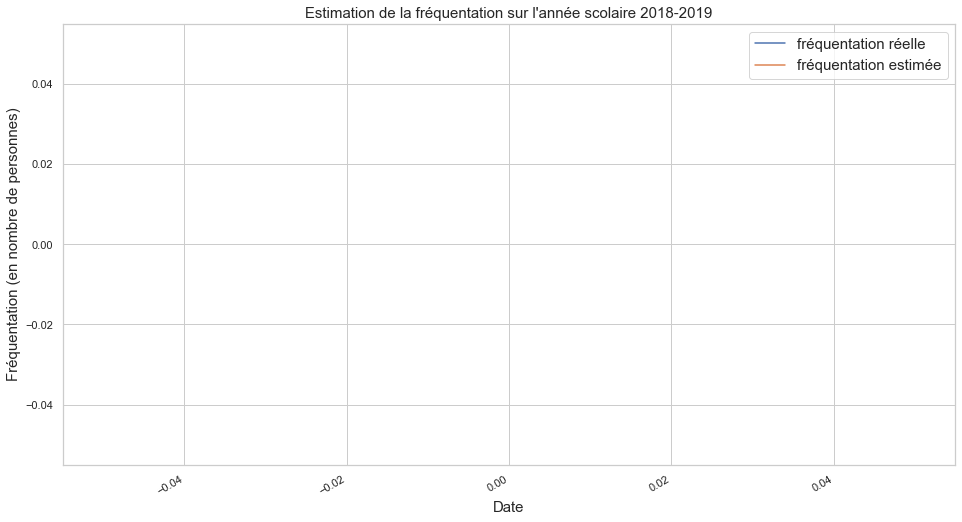

In [32]:
#On commence à entrainer le modèle à partir de l'année scolaire 2015-2016
#On test sur l'année 2018-2019

import statsmodels.api as sm

# train set
N_START = len(data_b) - len(data_b['2015-09':'2016-07'])- len(data_b['2016-09':'2017-07'])- len(data_b['2017-09':'2018-07'])- len(data_b['2018-09':'2019-07'])- len(data_b['2019-09':'2020-07'])
# test set
N_INT = len(data_b) - len(data_b['2018-09':'2019-07'])- len(data_b['2019-09':'2020-07'])-1
N_END = len(data_b) - len(data_b['2019-09':'2020-07'])-1

# construction du modèle de régression linéaire multiple de moindre carré ordinaire
mod = sm.regression.linear_model.OLS(y.iloc[N_START:N_INT], X.iloc[N_START:N_INT])

# lancement de l'entraînement
res = mod.fit()


print(res.summary())

dfm = data_b

# prédiction du modèle
y_pred = res.predict(X.iloc[N_INT:N_END]) 
y_true = y["reel"].iloc[N_INT:N_END]

# Visualisation
plt.figure(figsize=(16,9))
y_true.plot(label="fréquentation réelle")
y_pred.plot(label="fréquentation estimée")
plt.title("Estimation de la fréquentation sur l'année scolaire 2018-2019", fontsize=15)
plt.ylabel("Fréquentation (en nombre de personnes)", fontsize=15)
plt.xlabel("Date", fontsize=15)

plt.legend(fontsize=15)

In [33]:
train_data

,reel,effectif,porc,viande,poisson,bio,noel,an_chinois,plat_prepare,maison,laitage
date,,,,,,,,,,,
2015-09-01,10813.0,19066.0,0,1,0,0,0,0,0,0,0
2015-09-03,13066.0,19066.0,0,1,0,0,0,0,0,0,1
2015-09-04,13758.0,19066.0,0,1,0,0,0,0,1,0,1
2015-09-07,12789.0,19066.0,0,1,0,0,0,0,1,0,1
2015-09-08,13821.0,19066.0,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2018-06-29,13888.0,19958.0,0,0,1,1,0,0,1,0,1
2018-07-02,11873.0,19797.0,0,0,0,0,0,0,0,0,1
2018-07-03,11128.0,19557.0,0,1,0,1,0,0,1,0,0


In [34]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

y_predict_train = model_lr.predict(X_train)
MSE_train = mean_squared_error(y_train, y_predict_train)
RMSE_train = MSE_train** 0.5
print("MSE_train", MSE_train, "RMSE_train:", RMSE_train)

R2_square = (np.corrcoef(y_train, y_predict_train)[0,1])**2
print("R2_square :", R2_square)

y_predict_test = model_lr.predict(X_test)
MSE_test = mean_squared_error(y_test, y_predict_test)
RMSE_test = MSE_test ** 0.5
print("MSE_test:", MSE_test, "RMSE_test:", RMSE_test)

R2_square = (np.corrcoef(y_test, y_predict_test)[0,1])**2
print("R2_square :", R2_square)

MSE_train 421413.58630260784 RMSE_train: 649.1637592338376
R2_square : nan
MSE_test: 1174048.2536012481 RMSE_test: 1083.5350726216702
R2_square : nan


C:\Users\utilisateur\anaconda3\envs\Python 37\lib\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Users\utilisateur\anaconda3\envs\Python 37\lib\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\utilisateur\anaconda3\envs\Python 37\lib\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
C:\Users\utilisateur\anaconda3\envs\Python 37\lib\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Users\utilisateur\anaconda3\envs\Python 37\lib\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\utilisateur\anaconda3\envs\Python 37\lib\site-packages\numpy\lib\function_base.py:2480: Runtime

In [35]:
# corrélation entre variables
X_train = df
corrmatt = X_train.corr().round(2)
corrmatt

import seaborn as sns
plt.figure(figsize=(12,10))
mask=np.triu(np.ones_like(X_train.corr(),dtype=np.bool))
sns.heatmap(X_train.corr(), mask=mask,annot=True, vmin=-1,vmax=1, cmap='BrBG')
plt.show()

NameError: name 'df' is not defined

In [ ]:
# corrélation avec la variable cible
sorted_corrs_t = df.corr()['reel'].abs().sort_values(ascending=False)
sorted_corrs_t

plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df.corr()[['reel']].sort_values(by='reel', 
                                                                   ascending=False), vmin=-1, vmax=1, annot=True, 
                      cmap='BrBG')
#heatmap.set_title('Features Correlating with Sales Price', fontdict={'fontsize':18}, pad=16)

# Modélisation

## Régression linéaire

In [36]:
#df = df.groupby(df['date']).sum()
#df
temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92348 entries, 0 to 92347
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   site_nom            92348 non-null  object        
 1   annee_scolaire      92348 non-null  object        
 2   q_freq_01           92348 non-null  float64       
 3   q_freq_99           92348 non-null  float64       
 4   date                92348 non-null  datetime64[ns]
 5   jour                92348 non-null  object        
 6   semaine             92348 non-null  int64         
 7   mois                92348 non-null  object        
 8   menu                92348 non-null  object        
 9   gaspillage_volume   92348 non-null  int64         
 10  ferie               92348 non-null  int64         
 11  vacances            92348 non-null  int64         
 12  prevision           92200 non-null  float64       
 13  reel                92348 non-null  float64   

In [311]:
data.shape()

TypeError: 'tuple' object is not callable

In [298]:
temp = data.groupby('date').sum()
temp = temp.reset_index()
temp["mois"] = temp["date"].dt.month_name()

temp.mois[(temp['mois'] == 'January')] = 'Janvier'
temp.mois[(temp['mois'] == 'February')] = 'Fevrier'
temp.mois[(temp['mois'] == 'March')] = 'Mars'
temp.mois[(temp['mois'] == 'April')] = 'Avril'
temp.mois[(temp['mois'] == 'May')] = 'Mai'
temp.mois[(temp['mois'] == 'June')] = 'Juin'
temp.mois[(temp['mois'] == 'July')] = 'Juillet'
temp.mois[(temp['mois'] == 'September')] = 'Septembre'
temp.mois[(temp['mois'] == 'October')] = 'Octobre'
temp.mois[(temp['mois'] == 'November')] = 'Novembre'
temp.mois[(temp['mois'] == 'December')] = 'Decembre'

temp

C:\Users\utilisateur\anaconda3\envs\Python 37\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\utilisateur\anaconda3\envs\Python 37\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\utilisateur\anaconda3\envs\Python 37\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\utilisate

,date,nos,ind,semaine,gaspillage_volume,ferie,vacances,prevision,reel,effectif,mois
0,2011-01-03,87.0,0,87,100920,0,0,12289.0,11129.0,17373.0,Janvier
1,2011-01-04,0.0,0,87,65250,0,0,12558.0,11808.0,17373.0,Janvier
2,2011-01-06,0.0,0,87,88044,0,0,12753.0,11741.0,17373.0,Janvier
3,2011-01-07,0.0,0,87,42630,0,0,12812.0,12322.0,17373.0,Janvier
4,2011-01-10,0.0,0,174,87609,0,0,12309.0,11302.0,17373.0,Janvier
...,...,...,...,...,...,...,...,...,...,...,...
1087,2019-12-09,87.0,0,4350,443091,0,0,15991.0,10898.0,20685.0,Decembre
1088,2019-12-10,87.0,0,4350,821541,0,0,15885.0,6442.0,20685.0,Decembre
1089,2019-12-13,87.0,87,4350,719316,0,0,17436.0,9168.0,20685.0,Decembre
1090,2019-12-16,87.0,87,4437,321117,0,0,16062.0,12371.0,20685.0,Decembre


In [300]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1092 entries, 0 to 1091
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               1092 non-null   datetime64[ns]
 1   nos                1092 non-null   float64       
 2   ind                1092 non-null   int64         
 3   semaine            1092 non-null   int64         
 4   gaspillage_volume  1092 non-null   int64         
 5   ferie              1092 non-null   int64         
 6   vacances           1092 non-null   int64         
 7   prevision          1092 non-null   float64       
 8   reel               1092 non-null   float64       
 9   effectif           1092 non-null   float64       
 10  mois               1092 non-null   object        
dtypes: datetime64[ns](1), float64(4), int64(5), object(1)
memory usage: 94.0+ KB


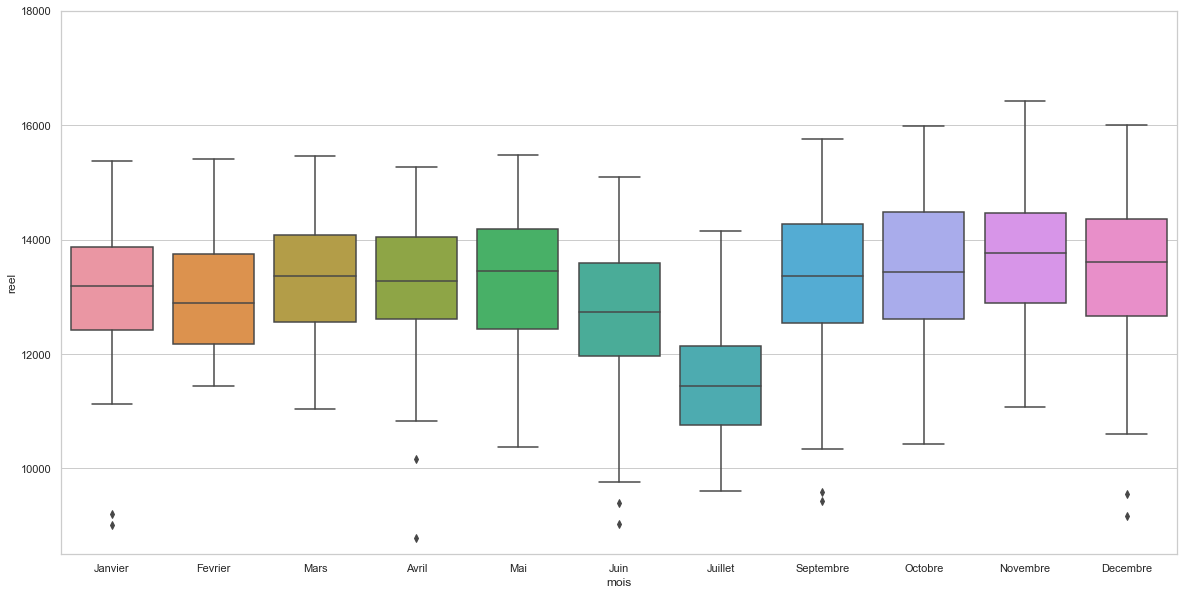

In [308]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.set(style='whitegrid')
ax.set(ylim=(8500, 18000))
ax = sns.boxplot(x='mois', y='reel', data=temp)

In [37]:
# remplacer le nombre dans chaque catégorie par l'effectif total annuel 
temp = data.groupby('date').sum()
temp.porc[(temp['porc'] > 1)] = 1
temp.viande[(temp['viande'] > 1)] = 1
temp.poisson[(temp['poisson'] > 1)] = 1
temp.bio[(temp['bio'] > 1)] = 1
temp.noel[(temp['noel'] > 1)] = 1 
temp.an_chinois[(temp['an_chinois'] > 1)] = 1
temp.plat_prepare[(temp['plat_prepare'] > 1)] = 1 
temp.maison[(temp['maison'] > 1)] = 1
temp.laitage[(temp['laitage'] > 1)] = 1

C:\Users\utilisateur\anaconda3\envs\Python 37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\utilisateur\anaconda3\envs\Python 37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\utilisateur\anaconda3\envs\Python 37\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyda

In [38]:
temp = temp.reset_index()
temp["jour"] = temp["date"].dt.day_name()
temp.jour[(temp['jour'] == 'Monday')] = 'Lundi'
temp.jour[(temp['jour'] == 'Tuesday')] = 'Mardi'
temp.jour[(temp['jour'] == 'Thursday')] = 'Jeudi'
temp.jour[(temp['jour'] == 'Friday')] = 'Vendredi'

temp["mois"] = temp["date"].dt.month_name()
temp.mois[(temp['mois'] == 'January')] = 'Janvier'
temp.mois[(temp['mois'] == 'February')] = 'Fevrier'
temp.mois[(temp['mois'] == 'March')] = 'Mars'
temp.mois[(temp['mois'] == 'April')] = 'Avril'
temp.mois[(temp['mois'] == 'May')] = 'Mai'
temp.mois[(temp['mois'] == 'June')] = 'Juin'
temp.mois[(temp['mois'] == 'July')] = 'Juillet'
temp.mois[(temp['mois'] == 'September')] = 'Septembre'
temp.mois[(temp['mois'] == 'October')] = 'Octobre'
temp.mois[(temp['mois'] == 'November')] = 'Novembre'
temp.mois[(temp['mois'] == 'December')] = 'Decembre'

temp["semaine"] = temp["date"].dt.week

temp["annee_scolaire"] = temp["date"]
temp

C:\Users\utilisateur\anaconda3\envs\Python 37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\utilisateur\anaconda3\envs\Python 37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\utilisateur\anaconda3\envs\Python 37\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyda

,date,semaine,gaspillage_volume,ferie,vacances,prevision,reel,effectif,porc,viande,poisson,plat_prepare,maison,laitage,bio,noel,an_chinois,jour,mois,annee_scolaire
0,2011-01-03,1,100920,0,0,12289.0,11129.0,17373.0,0,1,0,1,0,0,0,0,0,Lundi,Janvier,2011-01-03
1,2011-01-04,1,65250,0,0,12558.0,11808.0,17373.0,0,1,0,1,0,1,0,0,0,Mardi,Janvier,2011-01-04
2,2011-01-06,1,88044,0,0,12753.0,11741.0,17373.0,1,1,0,0,0,0,1,0,0,Jeudi,Janvier,2011-01-06
3,2011-01-07,1,42630,0,0,12812.0,12322.0,17373.0,0,0,1,0,0,1,0,0,0,Vendredi,Janvier,2011-01-07
4,2011-01-10,2,87609,0,0,12309.0,11302.0,17373.0,0,0,1,1,0,1,0,0,0,Lundi,Janvier,2011-01-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1056,2019-12-09,50,366696,0,0,13131.0,10898.0,16763.0,0,0,0,1,0,1,1,0,0,Lundi,Decembre,2019-12-09
1057,2019-12-10,50,594909,0,0,11367.0,6442.0,14640.0,1,1,0,0,0,1,1,0,0,Mardi,Decembre,2019-12-10
1058,2019-12-13,50,562224,0,0,13682.0,9168.0,15914.0,0,0,1,0,0,0,1,0,0,Vendredi,Decembre,2019-12-13
1059,2019-12-16,51,295280,0,0,14595.0,12371.0,18611.0,0,0,0,0,0,0,1,0,0,Lundi,Decembre,2019-12-16


In [40]:
temp = temp.set_index('date')
temp['annee_scolaire']['2010-09':'2011-07'] = '2010-2011'
temp['annee_scolaire']['2011-09':'2012-07'] = '2011-2012'
temp['annee_scolaire']['2012-09':'2013-07'] = '2012-2013'
temp['annee_scolaire']['2013-09':'2014-07'] = '2013-2014'
temp['annee_scolaire']['2014-09':'2015-07'] = '2014-2015'
temp['annee_scolaire']['2015-09':'2016-07'] = '2015-2016'
temp['annee_scolaire']['2016-09':'2017-07'] = '2016-2017'
temp['annee_scolaire']['2017-09':'2018-07'] = '2017-2018'
temp['annee_scolaire']['2018-09':'2019-07'] = '2018-2019'
temp['annee_scolaire']['2019-09':'2020-07'] = '2019-2020'
#temp.loc[(temp['annee_scolaire'] >= '2018-09') & (temp['annee_scolaire'] <= "2019-07")] = '2018-2019'
temp = temp.reset_index()

C:\Users\utilisateur\anaconda3\envs\Python 37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\utilisateur\anaconda3\envs\Python 37\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\utilisateur\anaconda3\envs\Python 37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

In [41]:
df = temp[["reel", "effectif", "annee_scolaire","semaine","mois", "jour", "porc", "viande", "bio", "poisson",
           "noel","date","plat_prepare","laitage","an_chinois"]]
df = df.set_index(df.date)

In [42]:
df

,reel,effectif,annee_scolaire,semaine,mois,jour,porc,viande,bio,poisson,noel,date,plat_prepare,laitage,an_chinois
date,,,,,,,,,,,,,,,
2011-01-03,11129.0,17373.0,2010-2011,1,Janvier,Lundi,0,1,0,0,0,2011-01-03,1,0,0
2011-01-04,11808.0,17373.0,2010-2011,1,Janvier,Mardi,0,1,0,0,0,2011-01-04,1,1,0
2011-01-06,11741.0,17373.0,2010-2011,1,Janvier,Jeudi,1,1,1,0,0,2011-01-06,0,0,0
2011-01-07,12322.0,17373.0,2010-2011,1,Janvier,Vendredi,0,0,0,1,0,2011-01-07,0,1,0
2011-01-10,11302.0,17373.0,2010-2011,2,Janvier,Lundi,0,0,0,1,0,2011-01-10,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-09,10898.0,16763.0,2019-2020,50,Decembre,Lundi,0,0,1,0,0,2019-12-09,1,1,0
2019-12-10,6442.0,14640.0,2019-2020,50,Decembre,Mardi,1,1,1,0,0,2019-12-10,0,1,0
2019-12-13,9168.0,15914.0,2019-2020,50,Decembre,Vendredi,0,0,1,1,0,2019-12-13,0,0,0


In [310]:
temp.shape()

TypeError: 'tuple' object is not callable

In [232]:
X = df[["reel", "effectif", "annee_scolaire","semaine", 
        "mois", "jour", "porc", "viande", "bio", "poisson","noel","plat_prepare","laitage","bio","an_chinois"]].dropna().sort_index()

Y = df[["reel"]]

# Get the dummies for the weekdays
X = pd.concat([pd.get_dummies(X["jour"], prefix=None), \
       pd.get_dummies(X["mois"], prefix=None), \
       X], axis=1)

X["poisson"] = X["poisson"] * X["effectif"]
X["viande"] = X["viande"] * X["effectif"]
#X["porc"] = X["porc"] * X["effectif"]
#X["vege"] = X["poisson"].apply(lambda x: 1-x)* X["viande"].apply(lambda x: 1-x)  * X["effectif"]

#Noel
X["noel"] = X["noel"] * X["effectif"]

#Bio
#X["bio"] = X["bio"] * X["effectif"]

#Mois
for i in df["mois"].unique():

    X[i] = X[i] * X["effectif"]

#X["4_premiers_jours"] = X["4_premiers_jours"] * X["effectif"]

#Ramadan
#X["ramadan"] = X["ramadan"] * X["effectif"]


#suppression des indicateurs non souhaités
X.drop("reel", axis=1, inplace=True)
X.drop("Vendredi", axis = 1, inplace = True)
X.drop("Lundi", axis = 1, inplace = True)
X.drop("Mardi", axis = 1, inplace = True)
X.drop("Jeudi", axis = 1, inplace = True)
#X.drop("Mercredi", axis = 1, inplace = True)
X.drop("porc", axis = 1, inplace = True)
#X.drop("viande", axis = 1, inplace = True)
#X.drop("poisson", axis = 1, inplace = True)
X.drop("jour", axis=1, inplace=True)
X.drop("semaine", axis=1, inplace=True)
X.drop("mois", axis=1, inplace=True)
X.drop("annee_scolaire", axis=1, inplace=True)
X.drop("Juillet", axis=1, inplace=True)
X.drop("bio", axis=1, inplace=True)
X.drop("Juin", axis=1, inplace=True)

X.drop("laitage", axis=1, inplace=True)
X.drop("plat_prepare", axis=1, inplace=True)
X.drop("an_chinois", axis=1, inplace=True)


In [233]:
#On commence à entrainer le modèle à partir de l'année scoalire 2015-2016
#On test sur l'année 2018-2019

# train set
N_START = len(df) - len(df[df['annee_scolaire']=="2015-2016"])- len(df[df['annee_scolaire']=="2016-2017"])- len(df[df['annee_scolaire']=="2017-2018"])- len(df[df['annee_scolaire']=="2018-2019"])- len(df[df['annee_scolaire']=="2019-2020"])

#test set
N_INT = len(df) - len(df[df['annee_scolaire']=="2018-2019"])- len(df[df['annee_scolaire']=="2019-2020"])-1
N_END = len(df) - len(df[df['annee_scolaire']=="2019-2020"])-1

#Régression avec les moindre carrés ordinaires (OLS)
mod = sm.regression.linear_model.OLS(Y.iloc[N_START:N_INT], X.iloc[N_START:N_INT]) 

#residuals = model.resid # On accède aux résidus du modèle
#test = sms.jarque_bera(residual) #Test de normalité

# entraînement du modèle
res = mod.fit()

print(res.summary())

dfm = data

# prédiction du modèle
y_pred = res.predict(X.iloc[N_INT:N_END]) 
y_true = Y["reel"].iloc[N_INT:N_END]

                                 OLS Regression Results                                
Dep. Variable:                   reel   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                          1.706e+04
Date:                Tue, 22 Feb 2022   Prob (F-statistic):                        0.00
Time:                        00:37:03   Log-Likelihood:                         -2963.1
No. Observations:                 382   AIC:                                      5952.
Df Residuals:                     369   BIC:                                      6003.
Df Model:                          13                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [276]:
# Préparation des données pour afficher la comparaison entre les valeurs prédites et estimées
X_pred = X.iloc[N_INT:N_END].join(data[["prevision", "reel","date",'nos','ind']].set_index('date').groupby("date").sum())
X_pred["pred"] = y_pred

# temp.porc[(temp['porc'] > 1)] = 1

X_pred.nos[(X_pred['nos'] > 0 )] = X_pred.reel
X_pred.ind[(X_pred['ind'] >0)] = X_pred.reel
X_pred["gaspillage"] = (X_pred["prevision"] - X_pred["reel"]) / X_pred["prevision"]
X_pred["gaspi_pred"] = (X_pred.pred - X_pred.reel) / X_pred.pred

C:\Users\utilisateur\anaconda3\envs\Python 37\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\utilisateur\anaconda3\envs\Python 37\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


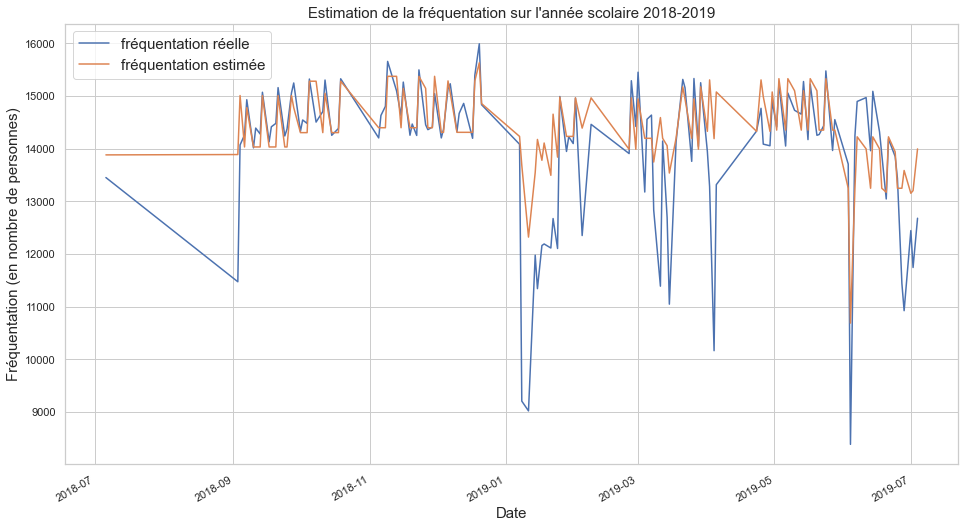

In [48]:
plt.figure(figsize=(16,9))
y_true.plot(label="fréquentation réelle")
y_pred.plot(label="fréquentation estimée")


plt.title("Estimation de la fréquentation sur l'année scolaire 2018-2019", fontsize=15)

plt.ylabel("Fréquentation (en nombre de personnes)", fontsize=15)
plt.xlabel("Date", fontsize=15)

plt.legend(fontsize=15)

Les prédictions sont trop justes, donc il faut calculer un paramètre alpha pour permettre d'ajuster les prévisions et d'éviter les jours de sous-production. Avoir des jours de sous-production conséquents n'est pas possible, car cela implique que des enfants ne mangent pas à la cantine.

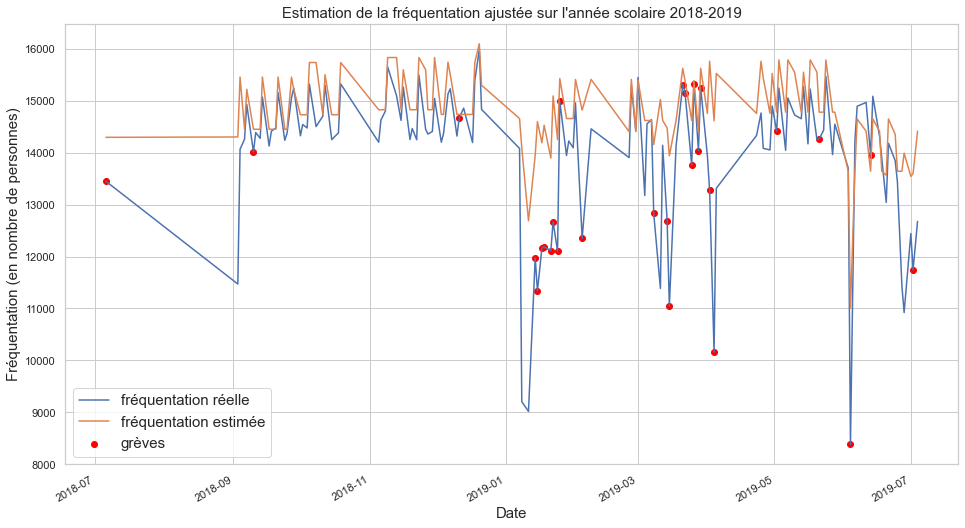

In [286]:
plt.figure(figsize=(16,9))

# prédiction *(1+ alpha)
y_pred_ajust = y_pred*(1+0.03)


y_true.plot(label="fréquentation réelle")
y_pred_ajust.plot(label="fréquentation estimée")

#plt.scatter(temp.date,temp.nos, color="red", label = "greves")
#plt.scatter(dfm.iloc[N_INT:N_END][X_pred.iloc[N_INT:N_END].ind > 1].index, X_pred.iloc[N_INT:N_END][X_pred.iloc[N_INT:N_END].ind > 1].reel, color="red", label = "greves")
#plt.scatter(X_pred.iloc[N_INT:N_END][X_pred.iloc[N_INT:N_END].nos > 1].index, X_pred.iloc[N_INT:N_END][X_pred.iloc[N_INT:N_END].nos > 1].reel, color="red")

plt.scatter(X_pred.nos[(X_pred['nos'] > 0 )].index, X_pred.nos[(X_pred['nos'] > 0 )], color="red", label = "grèves")
plt.scatter(X_pred.ind[(X_pred['ind'] > 0 )].index, X_pred.ind[(X_pred['ind'] > 0 )], color="red")

#X_pred.nos[(X_pred['nos'] > 0 )
plt.title("Estimation de la fréquentation ajustée sur l'année scolaire 2018-2019", fontsize=15)

plt.ylabel("Fréquentation (en nombre de personnes)", fontsize=15)
plt.xlabel("Date", fontsize=15)

plt.legend(fontsize=15)

In [50]:
data['gaspi_pour'] = ((data['prevision'] - data['reel']) / data['prevision']) * 100
data.gaspi_pour.mean()

-inf

In [52]:
# sauvegarde du modèle final choisi
from joblib import dump, load
dump(res, "res.joblib")

['res.joblib']

## Analyse des résultats

In [53]:
X_pred

,Avril,Decembre,Fevrier,Janvier,Mai,Mars,Novembre,Octobre,Septembre,effectif,viande,poisson,noel,prevision,reel,pred,gaspillage,gaspi_pred
date,,,,,,,,,,,,,,,,,,
2018-07-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19853.0,0.0,19853.0,0.0,14627.0,13451.0,13881.676239,0.080399,0.031025
2018-09-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20135.0,20135.0,20135.0,0.0,0.0,12780.0,11471.0,13888.207611,0.102426,0.174047
2018-09-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20344.0,20344.0,0.0,20344.0,0.0,14582.0,14070.0,15009.616591,0.035112,0.062601
2018-09-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20344.0,20344.0,20344.0,0.0,0.0,14553.0,14261.0,14032.366309,0.020065,-0.016293
2018-09-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20344.0,20344.0,0.0,0.0,0.0,15206.0,14930.0,14780.203389,0.018151,-0.010135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20344.0,20344.0,0.0,0.0,14897.0,11438.0,13247.744500,0.232194,0.136608
2019-06-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19429.0,0.0,19429.0,0.0,15301.0,10921.0,13585.205644,0.286256,0.196111
2019-07-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20197.0,20197.0,0.0,0.0,13848.0,12443.0,13152.020038,0.101459,0.053910


In [182]:
# analyse des résultats

X_pred["gaspillage"] = (X_pred["prevision"] - X_pred["reel"]) / X_pred["prevision"]
X_pred["pred_upper"] = predictions.summary_frame(alpha=0.3)['obs_ci_upper']
X_pred["gaspi_pred_upper"] = (X_pred.pred_upper - X_pred.reel) / X_pred.pred_upper

gaspi_reel = X_pred.gaspillage.mean()*100
gaspi_pred = X_pred.gaspi_pred_upper.mean()*100
print("gaspillage réel en pourcentage est de :  %.2f  " % gaspi_reel )
print("gaspillage avec nos prédictions:  %.2f " % gaspi_pred)

gaspillage réel en pourcentage est de :  8.02  
gaspillage avec nos prédictions:  6.53 


In [200]:
print("repas mqt reel :", X_pred[X_pred.gaspillage<0].gaspillage *X_pred[X_pred.gaspillage<0].reel)

repas mqt reel : date
2018-09-27   -164.783513
dtype: float64


In [192]:
print(len(X_pred[X_pred.gaspillage<0]), "jours réels avec un manque de repas")
print(len(X_pred[X_pred.gaspi_pred_upper<0]), "jours estimés pour lesquels il y aurait eu un manque de repas")
print(X_pred[X_pred.gaspi_pred_upper<0].pred_upper-X_pred[X_pred.gaspi_pred_upper<0].reel)
print("moyenne", (X_pred[X_pred.gaspi_pred_upper<0].pred_upper-X_pred[X_pred.gaspi_pred_upper<0].reel).mean())

1 jours réels avec un manque de repas
6 jours estimés pour lesquels il y aurait eu un manque de repas
date
2019-06-06   -394.061479
2019-06-07    -66.432586
2019-06-11   -364.742428
2019-06-13   -109.061479
2019-06-14   -259.432586
2019-06-18    -48.061479
dtype: float64
moyenne -206.96533944620901


In [99]:
abis = pd.read_csv('filebis.csv')
abis = abis.set_index('date')
abis

,Avril,Decembre,Fevrier,Janvier,Mai,Mars,Novembre,Octobre,Septembre,effectif,viande,poisson,noel
date,,,,,,,,,,,,,
2018-01-01,1,0,0,0,0,0,0,0,0,16763,16763,0,0
2018-01-02,1,0,0,0,0,0,0,0,0,16763,0,16763,0
2018-01-03,1,0,0,0,0,0,0,0,0,16763,0,0,0


In [100]:
abb = abis
pred = res.predict(abis)
abb['pred'] = pred
abb['pred'] = abb['pred'].astype(int)
abb

,Avril,Decembre,Fevrier,Janvier,Mai,Mars,Novembre,Octobre,Septembre,effectif,viande,poisson,noel,pred
date,,,,,,,,,,,,,,
2018-01-01,1,0,0,0,0,0,0,0,0,16763,16763,0,0,10915
2018-01-02,1,0,0,0,0,0,0,0,0,16763,0,16763,0,11721
2018-01-03,1,0,0,0,0,0,0,0,0,16763,0,0,0,11532


In [97]:
table_school = school[['site_nom','effectif','site_type', 'annee_scolaire']]
table_school = table_school.loc[(table_school['annee_scolaire'] == '2017-2018')]
table_school = table_school.apply(lambda x: x.astype(str).str.lower())
table_school['nom'] = table_school['site_nom']
table_school = table_school.drop(['site_nom'],axis=1)
table_school.reset_index()
table_school#.to_csv('table_school.csv')
table_school = table_school.drop_duplicates(keep='first',)
table_school = table_school.reset_index()
table_school = table_school.drop(['index'],axis=1)
table_school#.to_csv('table_school.csv')

,effectif,site_type,annee_scolaire,nom
0,412.0,m/e,2017-2018,urbain le verrier
1,367.0,e,2017-2018,marsauderies e
2,128.0,m,2017-2018,marsauderies m
3,329.0,m/e,2017-2018,batignolles
4,379.0,m/e,2017-2018,louis pergaud
...,...,...,...,...
84,269.0,m/e,2017-2018,harouys
85,349.0,m/e,2017-2018,emile pehant
86,105.0,m,2017-2018,stalingrad m
87,136.0,e,2017-2018,stalingrad e


In [143]:
abb

,Avril,Decembre,Fevrier,Janvier,Mai,Mars,Novembre,Octobre,Septembre,effectif,viande,poisson,noel,pred,pred_school
date,,,,,,,,,,,,,,,
2018-01-01,1,0,0,0,0,0,0,0,0,16763,16763,0,0,10915,NaN
2018-01-02,1,0,0,0,0,0,0,0,0,16763,0,16763,0,11721,NaN
2018-01-03,1,0,0,0,0,0,0,0,0,16763,0,0,0,11532,NaN


In [147]:
user = pd.DataFrame(data=[[0,'urbain le verrier']], columns=['id','nom'])
table_school = pd.DataFrame(table_school)
dfj = pd.merge(user, table_school, on='nom')
dfj['effectif'] = dfj['effectif'].astype(float)
dfj.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1 entries, 0 to 0
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              1 non-null      int64  
 1   nom             1 non-null      object 
 2   effectif        1 non-null      float64
 3   site_type       1 non-null      object 
 4   annee_scolaire  1 non-null      object 
dtypes: float64(1), int64(1), object(3)
memory usage: 48.0+ bytes


In [151]:
calcul = abb
calcul['pred_school'] = (abb['pred']/abb['effectif'])#*dfj['effectif']
#calcul['pred_school'] = calcul['pred_school'].mul(dfj['effectif'], axis=0)
calcul

,Avril,Decembre,Fevrier,Janvier,Mai,Mars,Novembre,Octobre,Septembre,effectif,viande,poisson,noel,pred,pred_school
date,,,,,,,,,,,,,,,
2018-01-01,1,0,0,0,0,0,0,0,0,16763,16763,0,0,10915,0.651136
2018-01-02,1,0,0,0,0,0,0,0,0,16763,0,16763,0,11721,0.699219
2018-01-03,1,0,0,0,0,0,0,0,0,16763,0,0,0,11532,0.687944


In [ ]:
(pred/effectif) x effectif_ecole